# Pipeline Exploration

The goal in this project is to define a liquid universe where we would apply our factors into it to see through our factor analysis if there is a potential or not. After selectioning and combining factors using Machine Learning technics, the combined factor is analysis then improved with an Optimizer function in order to integrate our Risk Model. 

This project workflow is comprised of distinct stages including: 

1. Parameters
2. Universe definition
3. Sector definition
4. Alpha factors
5. Factor analysis
6. Factors combination
7. Risk analysis for equal weights
8. Integrating factor data to optimizer
9. Optimized factor analysis
10. Predicted portfolio

In this context we have used different source of data provided from 
[Sharadar](https://www.quandl.com/publishers/sharadar) and 
[IFT](https://www.quandl.com/publishers/ift) as described below:

- Sharadar Equity Prices ([SHARADAR/SEP](https://www.quandl.com/databases/SEP/data))
Updated daily,End-Of-Day (EOD) price (ohlcv) data for more than 14,000 US public companies.  
- Indicator Descriptions ([SHARADAR/INDICATORS](https://www.quandl.com/databases/SF1/data))
Description of indicators listed in SF1 table for more than 14,000 US public companies.
- Tickers and Metadata ([SHARADAR/TICKERS](https://www.quandl.com/databases/SF1/data))
Information and meta data for more than 14,000 US public companies.
- Core US Fundamentals ([SHARADAR/SF1](https://www.quandl.com/databases/SF1/data))
 150 essential fundamental indicators and financial ratios, for more than 14,000 US public companies.
- Daily Metrics ([SHARADAR/DAILY](https://www.quandl.com/databases/SF1/data))
 5 essential metrics indicators and financial ratios daily updated, for more than 14,000 US public companies.
- Sentiment Analysis and News Analytics ([IFT/NSA](https://www.quandl.com/databases/NS1/data)) 
News, blogs, social media and proprietary sources for thousands of stocks.

Here below all packages needed for this project are imported. Before importing these packages we set our update_data value. we would like to choose to update our data or not. 

In [1]:
update_data = True
if update_data:
    print ('ready to update data from quandl')
else:
    print ('data is already updated') 

ready to update data from quandl


In [4]:
import pyfolio as pf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
import zipfile
import os
import alphalens as al
import quandl
import quantstats as qs
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
from sklearn import preprocessing
import pytz
import itertools
import warnings
from time import sleep

warnings.filterwarnings("ignore")

In [8]:
import risk_model
import factorize
import account
import utils_s
import feature_weights

In [10]:
secret_key = pd.read_csv('secret_key.txt',header=None)
quandl.ApiConfig.api_key = secret_key[0][0]

# 1 - Parameters

Before diving into factor research and quantitative analysis, we have to define parameters that will be use in different stage of this project. The purpose is to be able to try different parameters to optimize our output portfolio during time.

## 1 - 1 - Time series data parameters

In this part we set date parameters which is used for calling data from Quandl api. In this context we slice SEP/SHARADAR, DAILY/SHARADAR and IFT/NSA for three years data and SF1/SHARADAR for four years. The reason of this slicing is related to our final slicing for our factor pipeline which is for one year. For example for some factors our window length is set to one year, therefore we need to load minimum three years data to chunk the final dataframe in one year slice.

In [11]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))

current date: 2020-07-17
5 days ago: 2020-07-12
12 months ago: 2019-07-18


In [12]:
# SF1
some_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(some_years,month,day)
print ('SF1 data starting date: {}'.format(start_f))

SF1 starting date: 2016-7-17


In [13]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP,Daily and Sentiment data starting date: {}'.format(start_sep))

SEP and Daily starting date: 2017-7-17


## 1 - 2 - Factor data period parameter

We set our final date parameter to one year factor data. The reason is that we believe more than one year factor analysis will decrease our efficiency in prediction and could affect our interpretation of results.

In [148]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-7-17


## 1 - 3 - Universe filteration parameters

The universe filteration is an important step. Three parameters which will impact our analysis are represented below. `cap_select` is composed of market caps which are selected for our universe of stocks. `filteration_number` represents the number of liquid securities selected by dollar volume function and finally `smoothing_universe_period` represents the moving average length use in dollar volume function to select liquid securities. We will discuss about these parameters more in next sections.

In [14]:
cap_select = ['6 - Mega', '5 - Large', '4 - Mid']
filteration_number  = 1000
smoothing_universe_period = 100

## 1 - 4 - Multi factor analysis parameters

In [16]:
rebalance_period = 5
combined_periods = (3,5,10)

In [17]:
# Risk analysis
factor_exposures = 13

## 1 - 5 - Optimizer parameters

In [18]:
lambda_reg = 0.5
risk_cap = 0.05

## 1 - 6 - Sectors to drop

In [19]:
sec_to_drop = [ 
                'Basic Materials',
                'Industrials',
                'Healthcare',
                'Financial Services',
                'Communication Services',
                'Real Estate',
                'Energy',
                'Utilities'
              ]

In [20]:
drop_long_sec = []
drop_short_sec = []

## 1 - 8 - Factors

In [22]:
smoothed_value = 5

In [23]:
selected_indicators = ['cashneq']

In [24]:
momentum_in = {'momentum_252d':252}

In [25]:
sma_in = {'sma200':200}

In [26]:
daily_in = {'marketcap':100, 'evebitda':100}

In [27]:
over_in = {'overnight_sentiment_5d':5}

In [28]:
direction_in = {'direction_100d':100}

In [29]:
sent_in = {'sentiment_100d':100}

## 1 - 9 - Quantiles

In [30]:
qunatile_portions = 25

In [31]:
qunatile_to_analysis = [1,qunatile_portions]

## 1 - 10 - Long/Short leverage 

In [32]:
percent_long_leverage_target = 0.6
percent_short_leverage_target = 0.4

# 2 - Universe definition

## 2 - 1 - Get  META data

In [33]:
meta = quandl.get_table('SHARADAR/TICKERS', table='SF1',paginate=True)
meta.set_index('ticker',inplace=True, drop=True)

## 2 - 1 - 1 - First universe filteration

In [34]:
meta_ex = meta[(meta['exchange'] == 'NYSE') ^ (meta['exchange'] == 'NASDAQ')]
cap = []
for i in cap_select:
    cap.append(list(meta_ex[(meta_ex['scalemarketcap'] == i)].index))
meta_ex_sc = meta_ex.loc[list(itertools.chain.from_iterable(cap))]    
meta_ex_sc_cu = meta_ex_sc[(meta_ex_sc['currency'] == 'USD') & (meta_ex_sc['isdelisted'] == 'N')]

In [35]:
u1 = list(meta_ex_sc_cu.index)

In [36]:
print ('{} companies selected in first filteration'.format(len(u1)))

1984 companies selected in first filteration


## 2 - 2 - Get two years data for SEP

In [37]:
if update_data:
    quandl.export_table('SHARADAR/SEP',
                        ticker=u1, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename = 'data/ohlcv.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
data/ohlcv.zip


In [38]:
with zipfile.ZipFile('data/ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


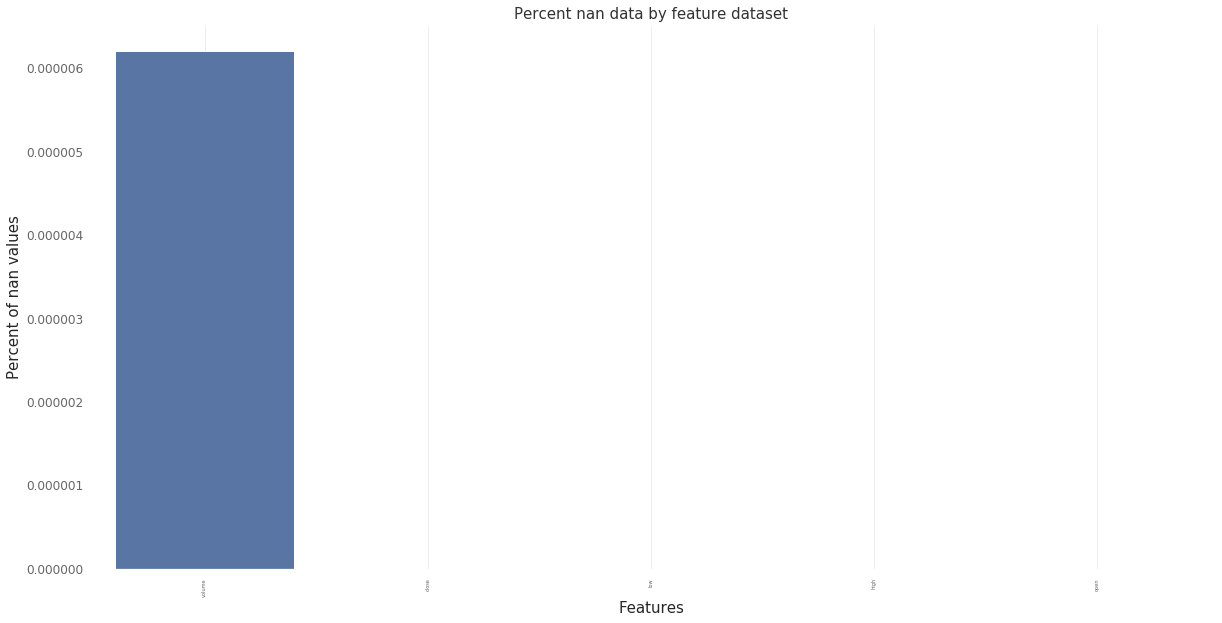

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [39]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

### 2 - 2 - 1 - Second universe filteration using Market Capitalization 

In [40]:
def dollar_volume_universe(tickers_num, ohlcv, sma_period):
    
    ohlcv['dollar_volume'] = ohlcv['close']*ohlcv['volume']
    dollar_vol = ohlcv['dollar_volume'].unstack('ticker')
    sma = pd.DataFrame(index = dollar_vol.index)
    try:
        for tick in dollar_vol.columns:
            sma[tick] = talib.SMA(dollar_vol[tick].values, timeperiod=sma_period)
    except:
        pass
    
    last = sma.iloc[-1,:]
    dol = pd.DataFrame(data = last.values,index = last.index, columns = ['dv'])
    dol.dropna(inplace = True)
    
    return list(dol.sort_values(by='dv', ascending=False).iloc[:tickers_num].index)    

In [41]:
universe = dollar_volume_universe(tickers_num = filteration_number, ohlcv = ohlcv, sma_period = smoothing_universe_period)

In [42]:
print ('{} companies selected out of {} for second filteration'.format(len(universe),len(u1)))

1000 companies selected out of 1984 for second filteration


#### Sector filteration

In [43]:
universe_sectors = pd.DataFrame(index=universe, columns=['sectors'])
for i in universe:
    universe_sectors.loc[i] = meta_ex_sc_cu.loc[i]['sector']
    
    for sec in sec_to_drop:
        if meta_ex_sc_cu.loc[i]['sector'] == sec:
            universe_sectors.drop(i, axis=0,inplace=True)

In [44]:
universe = list(universe_sectors.index)

In [45]:
print ('{} companies selected after sector drop out of {} for second filteration'.format(len(universe),len(u1)))

414 companies selected after sector drop out of 1984 for second filteration


## 2 - 3 - Get three years data for SF1

In [46]:
if update_data:
    #qopts={"columns":ind}
    quandl.export_table('SHARADAR/SF1',
                        ticker=universe, 
                        dimension = 'MRQ', 
                        calendardate={'gte':start_f,'lte':str(tod)}, 
                        filename='data/fundamental.zip')

We are generating the zip file now, please wait...
data/fundamental.zip


In [47]:
with zipfile.ZipFile('data/fundamental.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SF1':
        sf1 = pd.read_csv(item)
        sf1 = sf1.set_index(['calendardate', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sf1.drop(['datekey','reportperiod','lastupdated','dimension'],axis=1,inplace=True)
        os.remove(item)  

In [48]:
print ('the following tickers are not loaded in sf1:\n {}'.format(list(sf1.index.levels[1] ^ universe)))
print ('{} securities loaded out of {}'.format(len(sf1.index.levels[1]), len(universe)))

the following tickers are not loaded in sf1:
 ['BUD', 'CHKP', 'DOX', 'GDS', 'GLOB', 'INFY', 'MGA', 'MLCO', 'MTCH', 'NICE', 'STM', 'WB']
402 securities loaded out of 414


### 2 - 3 - 1 - Cleaning data

cleaning data
columns are clean


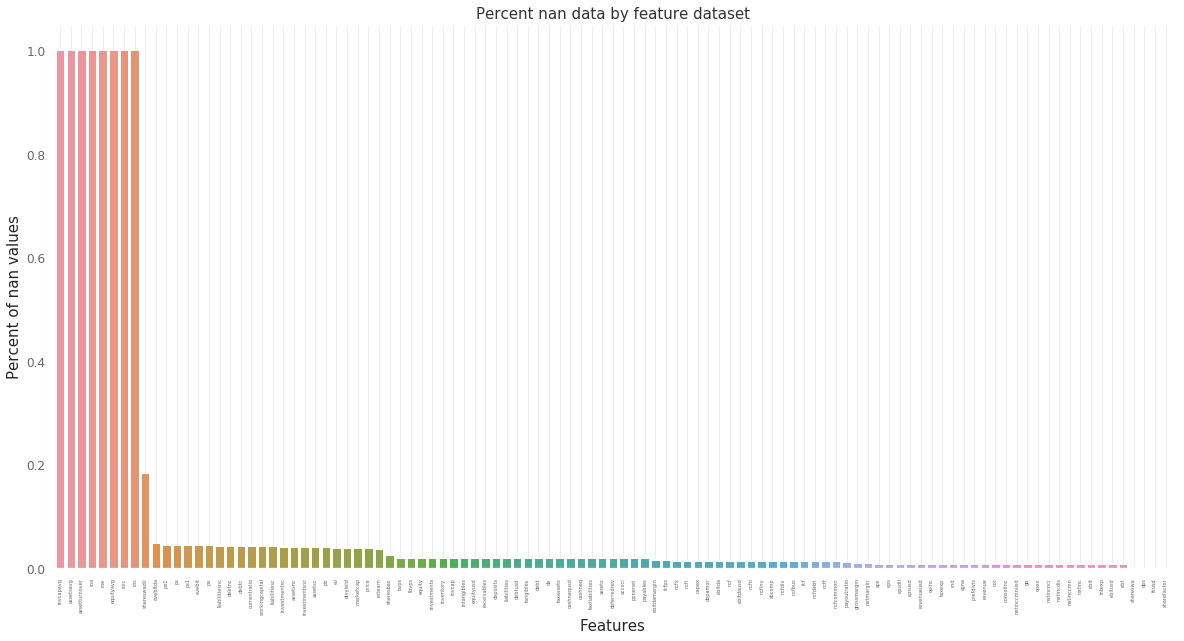

The percentage of dropped columns is 7%.
Dropped 8 columns out of 105


In [49]:
sf1 = utils_s.cleaning_dataframe(sf1,0.2)

In [50]:
sf1['roe'] = sf1['netinc'] / sf1['equity']
sf1['roa'] = sf1['netinc'] / sf1['assets']
sf1['fcf_yield'] = sf1['fcf'] / sf1['ev']

## 2 - 4 - Get two years data for DAILY

In [51]:
if update_data:
    quandl.export_table('SHARADAR/DAILY',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/daily.zip')

We are generating the zip file now, please wait...
data/daily.zip


In [52]:


with zipfile.ZipFile('data/daily.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'DAILY':
        daily = pd.read_csv(item)
        daily['date'] = pd.to_datetime(daily['date'])
        daily = daily.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        daily.drop(['lastupdated'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


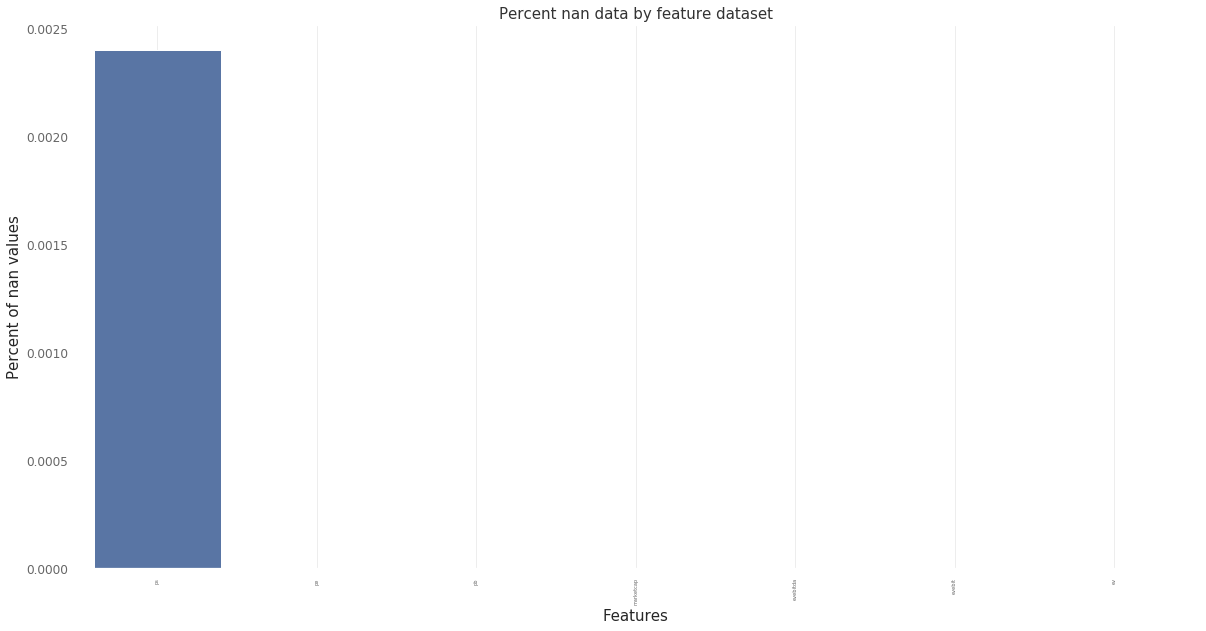

The percentage of dropped columns is 0%.
Dropped 0 columns out of 7


In [53]:
daily = utils_s.cleaning_dataframe(daily,0.2)

## 2 - 4 - Get two years data for SENTIMENT

In [54]:
if update_data:
    quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'
    quandl.export_table('IFT/NSA',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='data/sent.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
data/sent.zip


In [55]:
with zipfile.ZipFile('data/sent.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'IFT' and item.split('_')[1] == 'NSA':
        sent = pd.read_csv(item)
        sent['date'] = pd.to_datetime(sent['date'])
        sent = sent.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sent = sent[sent['exchange_cd']=='US']
        sent.drop(['name','exchange_cd'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


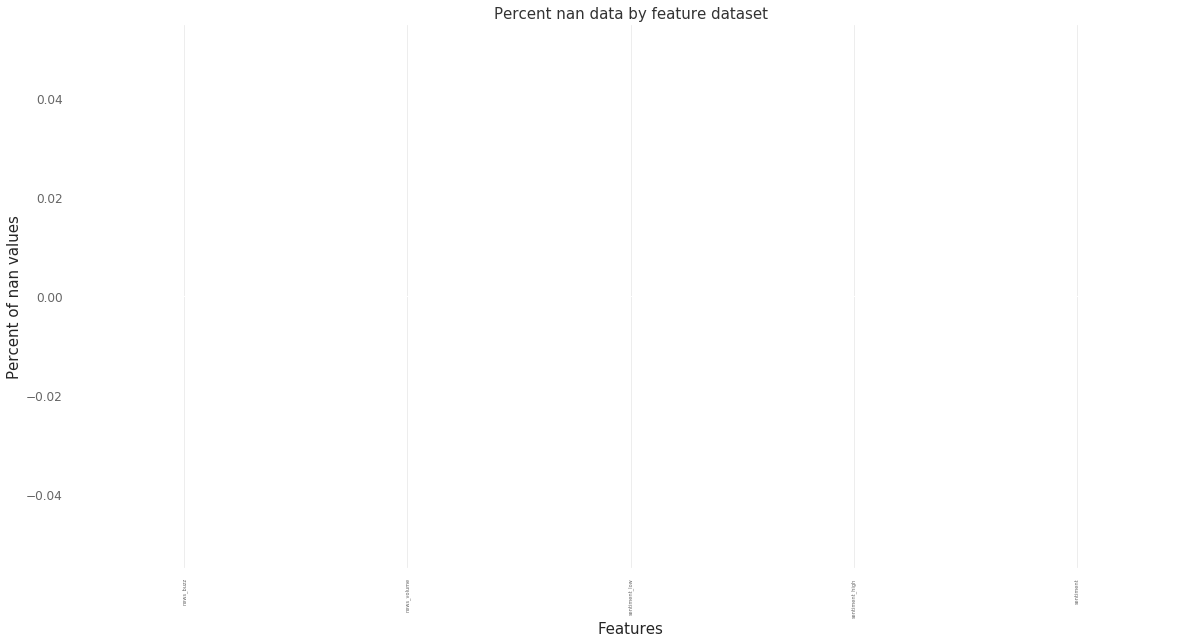

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [56]:
sent = utils_s.cleaning_dataframe(sent,0.2)

### Universe intersection

In [57]:
inter1 = set(sent['sentiment'].unstack('ticker').columns).intersection(set(sf1.index.levels[1]))
inter2 = inter1.intersection(set(daily.index.levels[1]))
inter3 = inter2.intersection(set(ohlcv.index.levels[1]))

new_universe = list(inter3)

In [58]:
len(new_universe)

373

# 3 - Sector definition

In [59]:
meta_cleaned = meta_ex_sc_cu.loc[new_universe,:]

In [60]:
print ('Sectors in filtered data: \n')
sectors = {}
for i in set(meta_cleaned['sector']):
    print (' ',i)
    sectors[i] = list(meta_cleaned[meta_cleaned['sector'] == i].index)

Sectors in filtered data: 

  Technology
  Consumer Cyclical
  Consumer Defensive


# 4 - Alpha factors

## 4 - 1 - Factorizing

In [61]:
close = ohlcv['close'].unstack('ticker')[new_universe]
openn = ohlcv['open'].unstack('ticker')[new_universe]
high = ohlcv['high'].unstack('ticker')[new_universe]
low = ohlcv['low'].unstack('ticker')[new_universe]

In [62]:
#close.to_csv('close.csv')

In [63]:
pricing = openn.loc[slice(start,end),:].tz_localize('UTC')[new_universe]

In [64]:
# daily

daily_data = {}

for i in daily_in.keys():
    
    df_daily = daily[i].unstack('ticker')
    reversion = factorize.Momentum(df_daily,daily_in[i])*-1
    smoothed_reversion = factorize.Smooth(reversion,smoothed_value)
    smoothed_reversion.index = pd.to_datetime(smoothed_reversion.index)
    smoothed_reversion = smoothed_reversion.loc[slice(start,end),:]

    result = []
    for sec in sectors.keys():
        result.append(smoothed_reversion[sectors[sec]].sub(smoothed_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_reversion_neutralized = pd.concat(result,axis=1)
    smoothed_reversion_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_reversion_neutralized),
                                                         index = smoothed_reversion_neutralized.index,
                                                         columns = smoothed_reversion_neutralized.columns)
    
    daily_data[i] = smoothed_reversion_neutralized_scaled


In [65]:
# SMA
sma_data = {}

for name,period in sma_in.items():

    df= pd.DataFrame(index = close.index)

    try:
        for tick in close.columns:
            df[tick] = talib.SMA(close[tick].values, timeperiod=period)
    except:
        pass

    sma_min = (close - df)*-1
    smoothed_sma_min = factorize.Smooth(sma_min,smoothed_value)
    smoothed_sma_min.index = pd.to_datetime(smoothed_sma_min.index)
    smoothed_sma_min = smoothed_sma_min.loc[slice(start,end),:]
    
    # Neutralizing by sector
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sma_min[sectors[sec]].sub(smoothed_sma_min[sectors[sec]].mean(axis=1),axis=0))

    smoothed_sma_min_neutralized = pd.concat(result,axis=1)    
    
    smoothed_sma_min_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_sma_min_neutralized),
                                                              index = smoothed_sma_min_neutralized.index,
                                                              columns = smoothed_sma_min_neutralized.columns)
    
    sma_data[name] = smoothed_sma_min_neutralized_scaled
    

In [66]:
over_data = {}

for name,period in over_in.items():
    overnight_sentiment = factorize.overnight_sentiment(close, openn, window_length=1, trailing_window=period)*-1
    smoothed_overnight_sentiment = factorize.Smooth(overnight_sentiment,smoothed_value)
    
    smoothed_overnight_sentiment.index = pd.to_datetime(smoothed_overnight_sentiment.index)
    
    smoothed_overnight_sentiment = smoothed_overnight_sentiment.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_overnight_sentiment[sectors[sec]].sub(smoothed_overnight_sentiment[sectors[sec]].mean(axis=1),axis=0))

    smoothed_overnight_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    over_data[name] = smoothed_overnight_sentiment_neutralized_scaled
    

In [67]:
# mean reversion
momentum_data = {}

for name,period in momentum_in.items():
    
    mean_reversion = factorize.Momentum(close,period)*-1
    smoothed_mean_reversion = factorize.Smooth(mean_reversion,smoothed_value)
    
    smoothed_mean_reversion.index = pd.to_datetime(smoothed_mean_reversion.index)
    smoothed_mean_reversion = smoothed_mean_reversion.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_mean_reversion[sectors[sec]].sub(smoothed_mean_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_mean_reversion_neutralized_scaled = pd.concat(result,axis=1)
  
    momentum_data[name] = smoothed_mean_reversion_neutralized_scaled


In [68]:
# direction
direction_data = {}

for name,period in direction_in.items():
    
    direct = factorize.direction(close, openn, 1, period)
    smoothed_direct = factorize.Smooth(direct,smoothed_value)

    smoothed_direct.index = pd.to_datetime(smoothed_direct.index)
    smoothed_direct = smoothed_direct.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_direct[sectors[sec]].sub(smoothed_direct[sectors[sec]].mean(axis=1),axis=0))

    smoothed_direct_neutralized_scaled = pd.concat(result,axis=1)
    
    direction_data[name] = smoothed_direct_neutralized_scaled

In [69]:
# sentiment
sent_data = {}

for name,period in sent_in.items():
    
    sentiment = factorize.sentiment(close, high, low, sent, period, new_universe)
    smoothed_sentiment= factorize.Smooth(sentiment,smoothed_value)
    smoothed_sentiment.index = pd.to_datetime(smoothed_sentiment.index)
    smoothed_sentiment = smoothed_sentiment.loc[slice(start,end),:]
    
    to_drop = smoothed_sentiment.columns ^ close.columns

    for i in to_drop:
        sectors[meta_cleaned.loc[i]['sector']].remove(i)
        
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sentiment[sectors[sec]].sub(smoothed_sentiment[sectors[sec]].mean(axis=1),axis=0))
    
    smoothed_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    sent_data[name] = smoothed_sentiment_neutralized_scaled

## 4 - 2 - Fundamentals 

### 4 - 2 - 1 - Indicators

In [70]:
#indicator=ind
indicators_desc = quandl.get_table('SHARADAR/INDICATORS')
sf1_ind = indicators_desc[indicators_desc['table']=='SF1']

In [71]:
# Columns description of cleaned SF1
for i in sf1.columns:
    try:
        print (i,':',sf1_ind[sf1_ind['indicator']==i]['title'].values[0],':',sf1_ind[sf1_ind['indicator']==i]['description'].values[0],'\n')
    except:
        pass

accoci : Accumulated Other Comprehensive Income : [Balance Sheet] A component of [Equity] representing the accumulated change in equity from transactions and other events and circumstances from non-owner sources; net of tax effect; at period end. Includes foreign currency translation items; certain pension adjustments; unrealized gains and losses on certain investments in debt and equity securities. 

assets : Total Assets : [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables]. 

assetsc : Current Assets : [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets. 

assetsnc : Assets Non-Current : [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total As

### 4 - 2 - 2 - Factorizing, Neutralizing and Resampling

In [72]:
data = {}
for i in selected_indicators:
    
    df = sf1[i].unstack('ticker')[new_universe]
    df.fillna(df.mean(axis=0),inplace=True)
    
    # Calculating Return
    returns = factorize.Returns(df,window_length=1)
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)    
    
    returns_drz = pd.DataFrame(data = preprocessing.scale(returns),
                               index = returns.index,
                               columns = returns.columns) 

    result = []
    for sec in sectors.keys():
        result.append(returns_drz[sectors[sec]].sub(returns[sectors[sec]].mean(axis=1),axis=0))
    
    returns_neutralize = pd.concat(result,axis=1)

    # Resampling
    chunk = (ohlcv.index.levels[0][-1]+datetime.timedelta(days=1)).date()
    chunk_minus = ohlcv.index.levels[0][-1].date()
    returns_neutralize.loc[chunk,:] = np.nan
    returns_neutralize.index = pd.to_datetime(returns_neutralize.index)
    returns_neutralize_resampled = returns_neutralize.resample('D').pad()
    returns_neutralize_resampled = returns_neutralize_resampled.loc[start_sep:chunk_minus,:]
    
    # Drop holidays
    holidays = returns_neutralize_resampled.index ^ ohlcv.index.levels[0]
    returns_neutralize_resampled.drop(list(holidays),axis=0,inplace = True)
    returns_neutralize_resampled.index.name = ohlcv.index.levels[0].name
    
    # Slicing 1 year
    returns_neutralize_resampled_1y = returns_neutralize_resampled.loc[slice(start,end),:]

    data[i] = returns_neutralize_resampled_1y

## 4 - 4 - Multiindex factors

In [73]:
result = []

for ind in selected_indicators:
    
    fund_return_neutralized_stacked = data[ind].stack().to_frame(ind)
    result.append(fund_return_neutralized_stacked)

for i in daily_in.keys():

    daily_stacked = daily_data[i].stack().to_frame('daily_{}{}days'.format(i,daily_in[i]))
    result.append(daily_stacked)

for i in sma_data.keys():

    sma_stacked = sma_data[i].stack().to_frame('sma{}'.format(sma_in[i]))
    result.append(sma_stacked)

for i in momentum_data.keys():
    
    momentum_stacked = momentum_data[i].stack().to_frame('momentum{}days'.format(momentum_in[i]))
    result.append(momentum_stacked)
    
for i in over_data.keys():
    
    over_stacked = over_data[i].stack().to_frame('overnight_sent{}days'.format(over_in[i]))
    result.append(over_stacked)    

for i in direction_data.keys():
    
    direct_stacked = direction_data[i].stack().to_frame('direction{}days'.format(direction_in[i]))
    result.append(direct_stacked)

for i in sent_data.keys():
    
    sent_stacked = sent_data[i].stack().to_frame('sentiment{}days'.format(sent_in[i]))
    result.append(sent_stacked)    
    
all_factors = pd.concat(result,axis=1)

all_factors.index = all_factors.index\
                               .set_levels([all_factors.index.levels[0].tz_localize('UTC'), all_factors.index.levels[1]])
#all_factors.dropna(axis=0, inplace = True)
all_factors

cashneq  daily_marketcap100days  \
date                      ticker                                     
2019-07-17 00:00:00+00:00 OLED    0.803412               -1.541078   
                          AMAT   -0.074383                0.432513   
                          PSTG   -0.960239                0.865320   
                          COMM    1.258426                0.774896   
                          TER     0.141931                1.230167   
                          SNAP    0.688772               -0.481376   
                          HPQ     1.491110                0.628407   
                          LOGM   -0.964547                1.295902   
                          ARW    -0.756265                0.827886   
                          VRSN    0.293784               -1.448924   
                          AAPL    1.074204                0.958221   
                          MELI   -0.292459               -1.761358   
                          EVBG    0.248963               -0.616777   
                          UBER    1.819529               -0.231155   
                          MRVL    0.175004               -1.082012   
                          CYBR    0.332007               -1.956958   
                          ZS      0.720719               -0.654201   
                          FFIV   -0.263427                1.620109   
                          APPN    0.372966                0.950898   
                          MANH    0.753316               -0.627852   
                          BR     -0.181598               -1.853824   
                          LRCX   -0.483487                1.505494   
                          TTD    -0.126358               -1.048550   
                          CDNS    0.796819               -1.436004   
                          FB      0.658984               -2.210383   
                          MU     -1.262069                1.175724   
                          FLIR    0.059183               -0.265242   
                          IRBT   -0.481083                0.267477   
                          OKTA    0.302330               -0.900743   
                          FIS     0.845191                0.511460   
...                                    ...                     ...   
2020-07-16 00:00:00+00:00 PFGC   -0.759412                1.823855   
                          MO     -0.634290               -0.379168   
                          SAFM    2.581702                0.583246   
                          POST    0.965283                1.333104   
                          KMB    -0.795557                0.175970   
                          CAG     1.950207               -1.591274   
                          TWOU    2.069578               -0.854046   
                          RAD     1.323057               -0.151665   
                          INGR    2.216888                0.761685   
                          SJM    -1.567403               -0.013834   
                          MKC     1.051265               -1.903846   
                          SAM     0.946500               -1.349138   
                          TAP     1.219013                2.475095   
                          KDP     1.179051               -0.539660   
                          COST    2.360676                1.030689   
                          WMT    -1.399298               -1.232859   
                          PEP     0.269445                1.748069   
                          WBA     1.168497                0.861990   
                          NWL     1.639388                0.418461   
                          DLTR   -1.173637               -1.107889   
                          BG      2.257076                0.675227   
                          PG     -1.678988                0.272345   
                          SFM    -0.490022               -1.629825   
                          ADM    -2.660975                0.187072   
                          HLF     1.487363   

In [74]:
all_factors.isna().sum()

cashneq                   0
daily_marketcap100days    0
daily_evebitda100days     0
sma200                    0
momentum252days           0
overnight_sent5days       0
direction100days          0
sentiment100days          0
dtype: int64

# 5 - All factors analysis

In [75]:
print ('Rebalance period set to {} days for factor analysis'.format(rebalance_period))

Rebalance period set to 5 days for factor analysis


In [76]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                          prices=pricing, 
                                                          periods=[rebalance_period], 
                                                          quantiles=5,
                                                          filter_zscore=20,
                                                          max_loss=0.35)
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% en

### 5 - 1 - Cumulated factor return

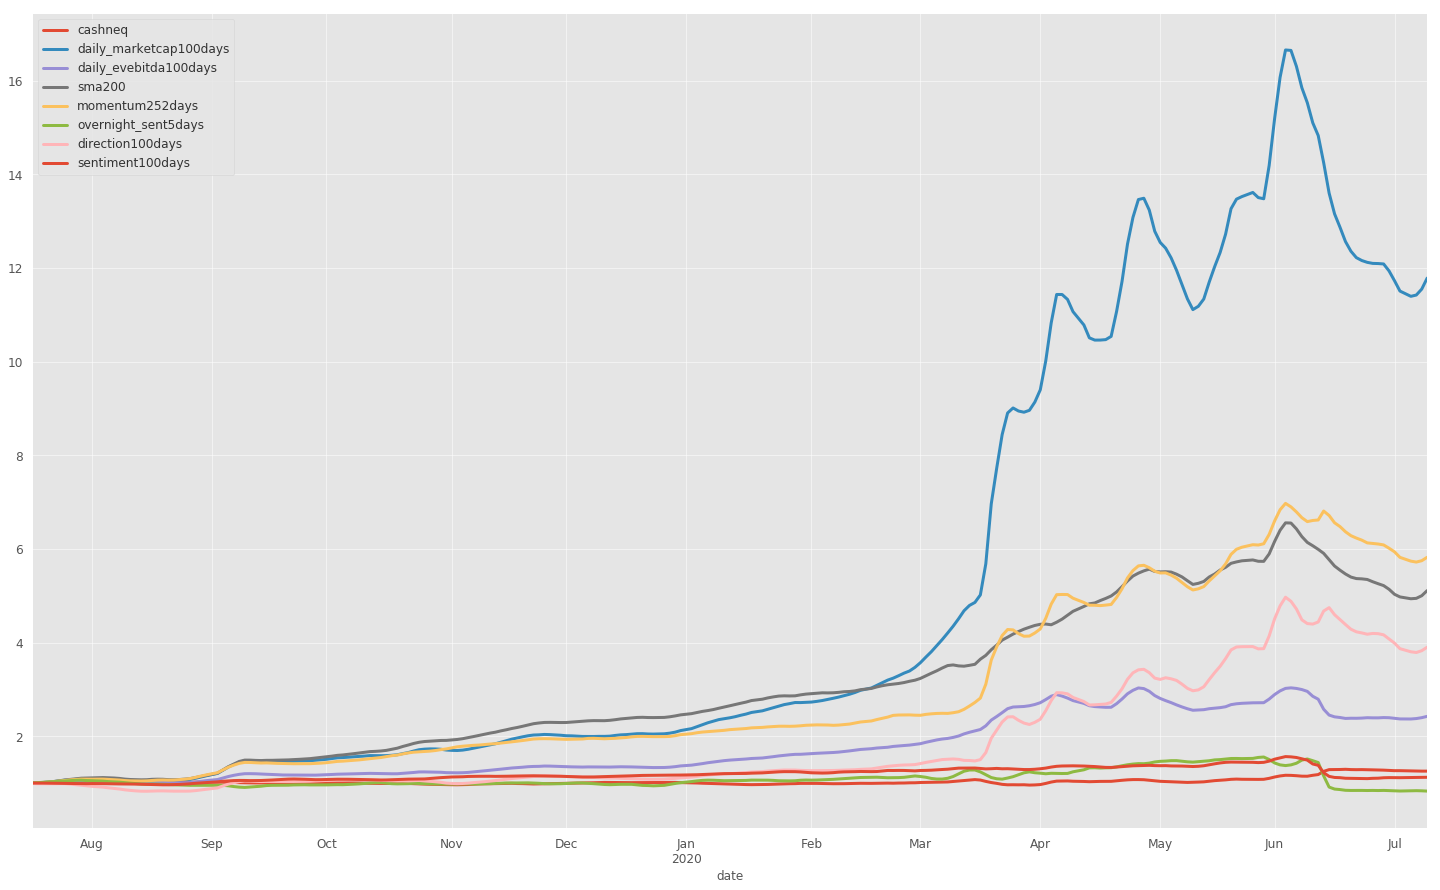

In [77]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 15)

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot(lw=3);

### 5 - 2 - Quantile analysis

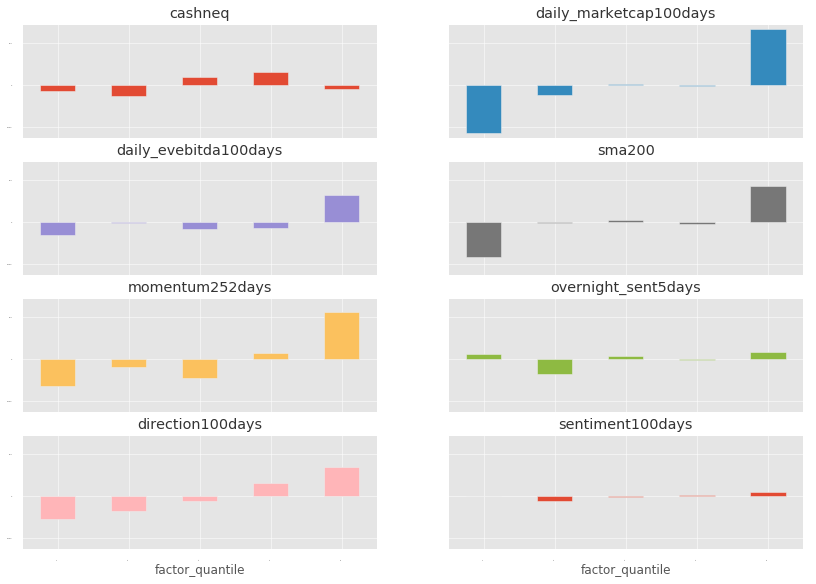

In [78]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(20,2),
    figsize=(14, 50),
    legend=False, fontsize=2);

### 5 - 3 - Factor Rank Autocorrelation

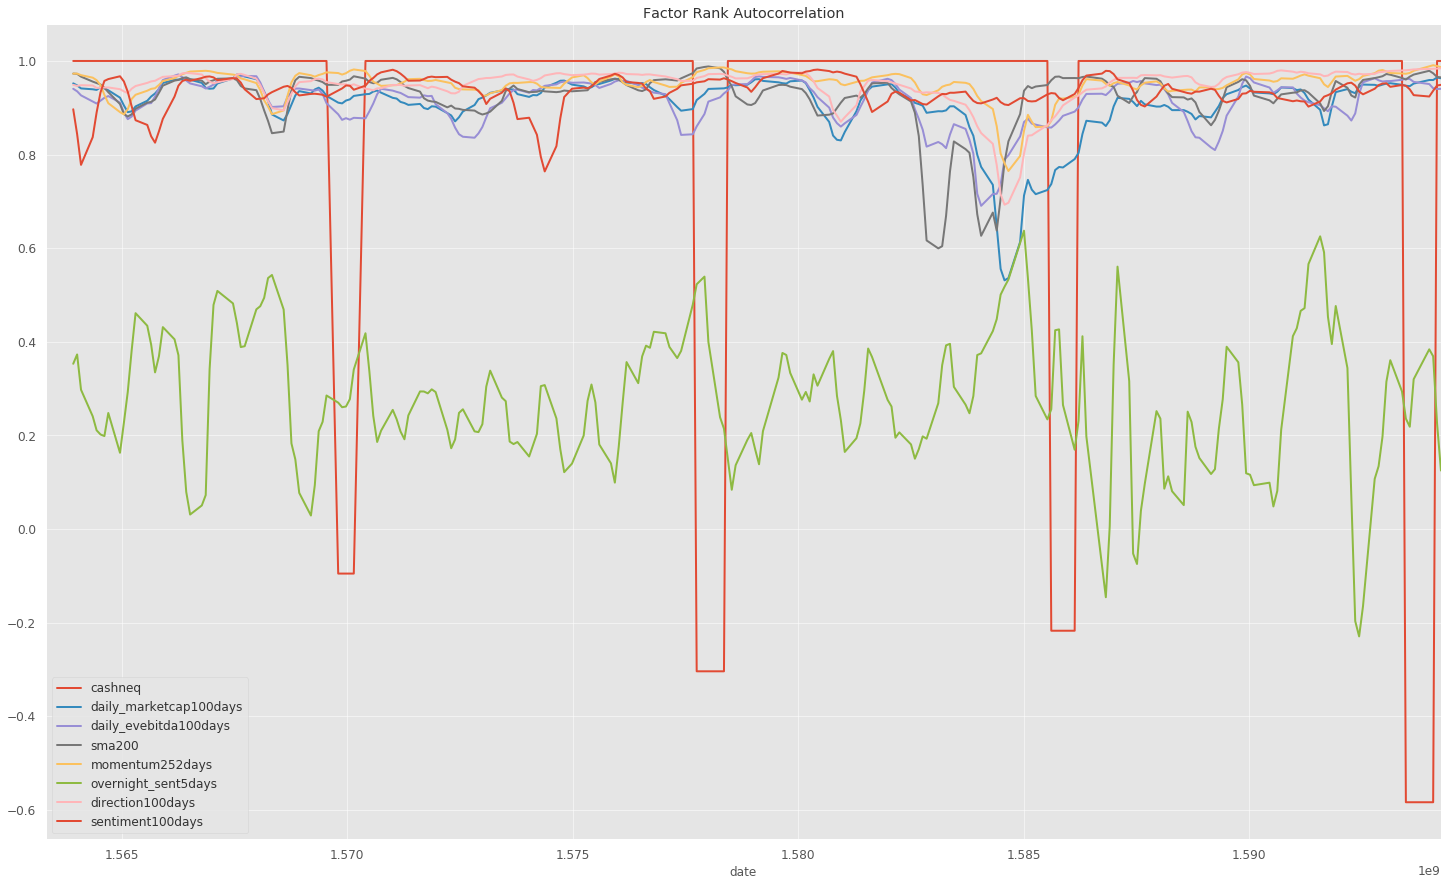

In [79]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data,period=rebalance_period)

ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

### 5 - 4 - Sharpe ratio

In [80]:
def sharpe_ratio(factor_returns, annualization_factor):

    df_sharpe = pd.Series(annualization_factor*factor_returns.mean()/factor_returns.std())
    
    return df_sharpe

In [81]:
daily_annualization_factor = np.sqrt(252)
df_sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [82]:
df_sharpe.sort_values(ascending=False)

sma200                    9.07
daily_marketcap100days    6.28
momentum252days           6.19
daily_evebitda100days     4.50
direction100days          3.72
cashneq                   2.01
sentiment100days          0.80
overnight_sent5days      -0.33
dtype: float64

# 6 - Combined factors

## 6 - 1 - Combining selceted factors

In [83]:

selected_factors = [
                         'sma200',
                         'daily_marketcap100days',
                         'direction100days',
                         'momentum252days',
                         'sentiment100days',
                         'cashneq'
                   ]

print('Selected Factors:\n{} '.format(',\n'.join(selected_factors)))

all_factors = all_factors[selected_factors]

Selected Factors:
sma200,
daily_marketcap100days,
direction100days,
momentum252days,
sentiment100days,
cashneq 


Time to train full ML pipline: 1.5267868041992188 secs
Accuracy on train set = 50.73%
Predictions: [1. 1. 1. ... 1. 1. 1.]
Probabilities of class == 1: [50.00001519 50.00001519 50.00001519 ... 50.00001519 50.00001519
 50.00001519]
Accuracy on test set = 49.87%
Log-loss = 0.69315


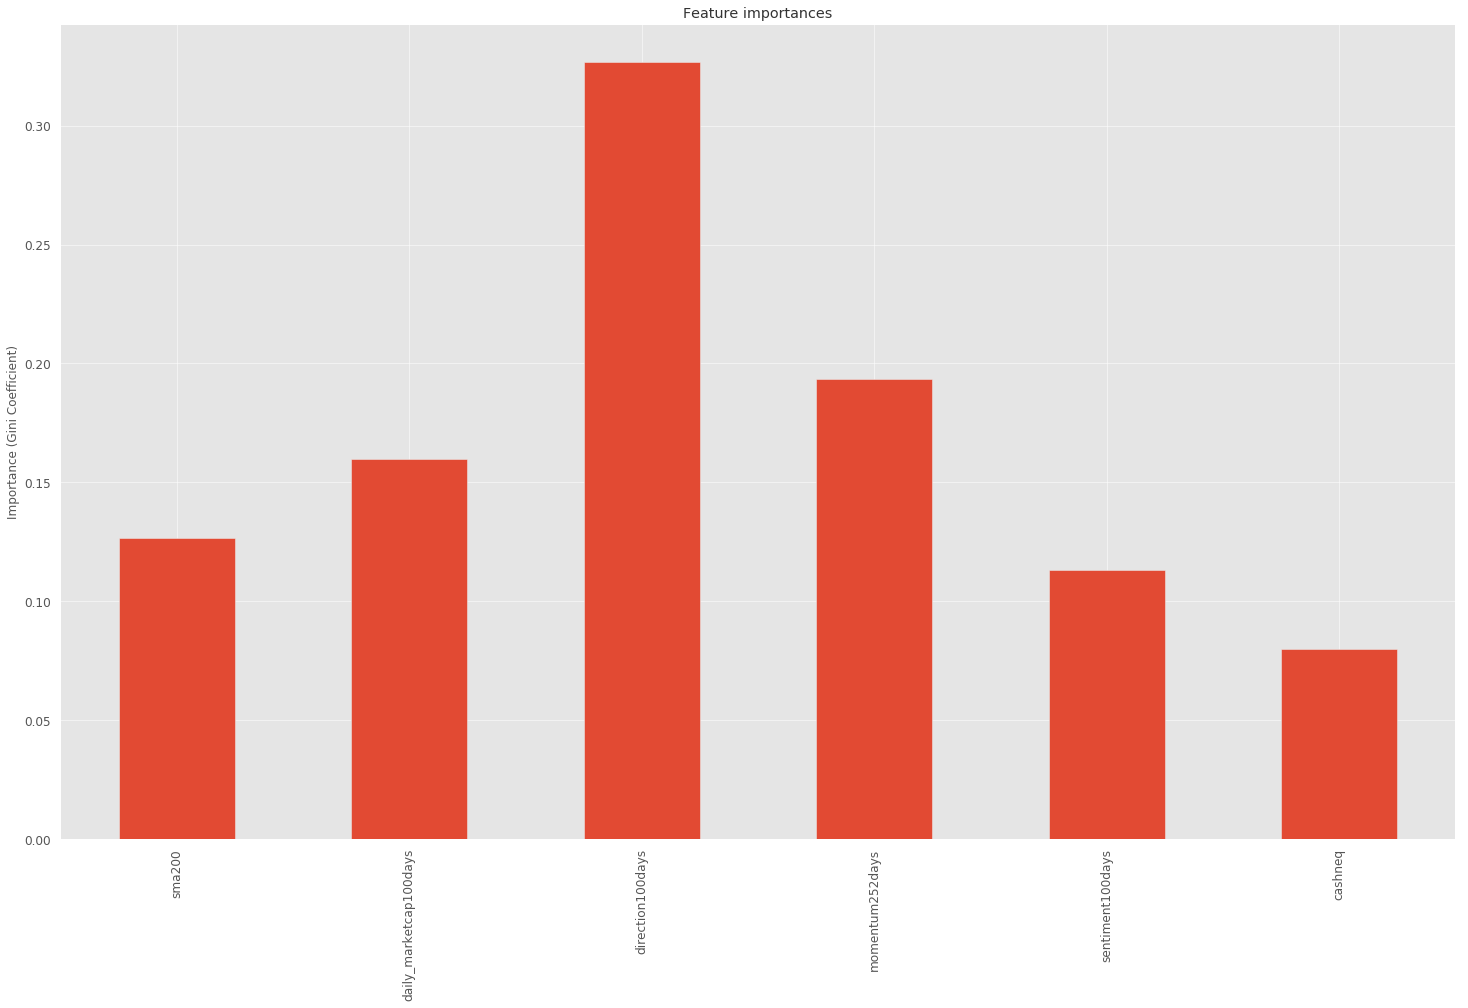

In [84]:
feature_importances = feature_weights.feature_importance(n_fwd_days = rebalance_period, 
                                                         close = close, 
                                                         all_factors = all_factors)

In [85]:
feature_importances

weights
factors                         
sma200                  0.126667
daily_marketcap100days  0.160000
direction100days        0.326667
momentum252days         0.193333
sentiment100days        0.113333
cashneq                 0.080000

In [86]:
all_factors_copy = all_factors.copy() 

In [87]:
for factor in selected_factors:
    all_factors_copy.loc[:,factor] = feature_importances.loc[factor][0] * all_factors.loc[:,factor]
all_factors_copy.loc[:,'alpha_vector'] = all_factors.sum(axis=1)
all_factors = all_factors_copy  

In [88]:
vec = pd.DataFrame(data=all_factors['alpha_vector'],columns = ['alpha_vector','sector'])
for date in vec.index.levels[0]:
    vec.loc[date,['sector']] = meta_ex_sc_cu.loc[vec.index.levels[1]]['sector'].values
sectors = vec['sector']

In [89]:
vec.shape

(94369, 2)


## 6 - 2 - Creating clean factor data

In [90]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = all_factors['alpha_vector'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = qunatile_portions,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 6 - 3 - Creating tear sheets 

In [91]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period='{}D'.format(rebalance_period),
                                       capital=10000,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       #quantiles=[1,2,4,5],
                                       groups=sectors,
                                       benchmark_period='{}D'.format(rebalance_period))

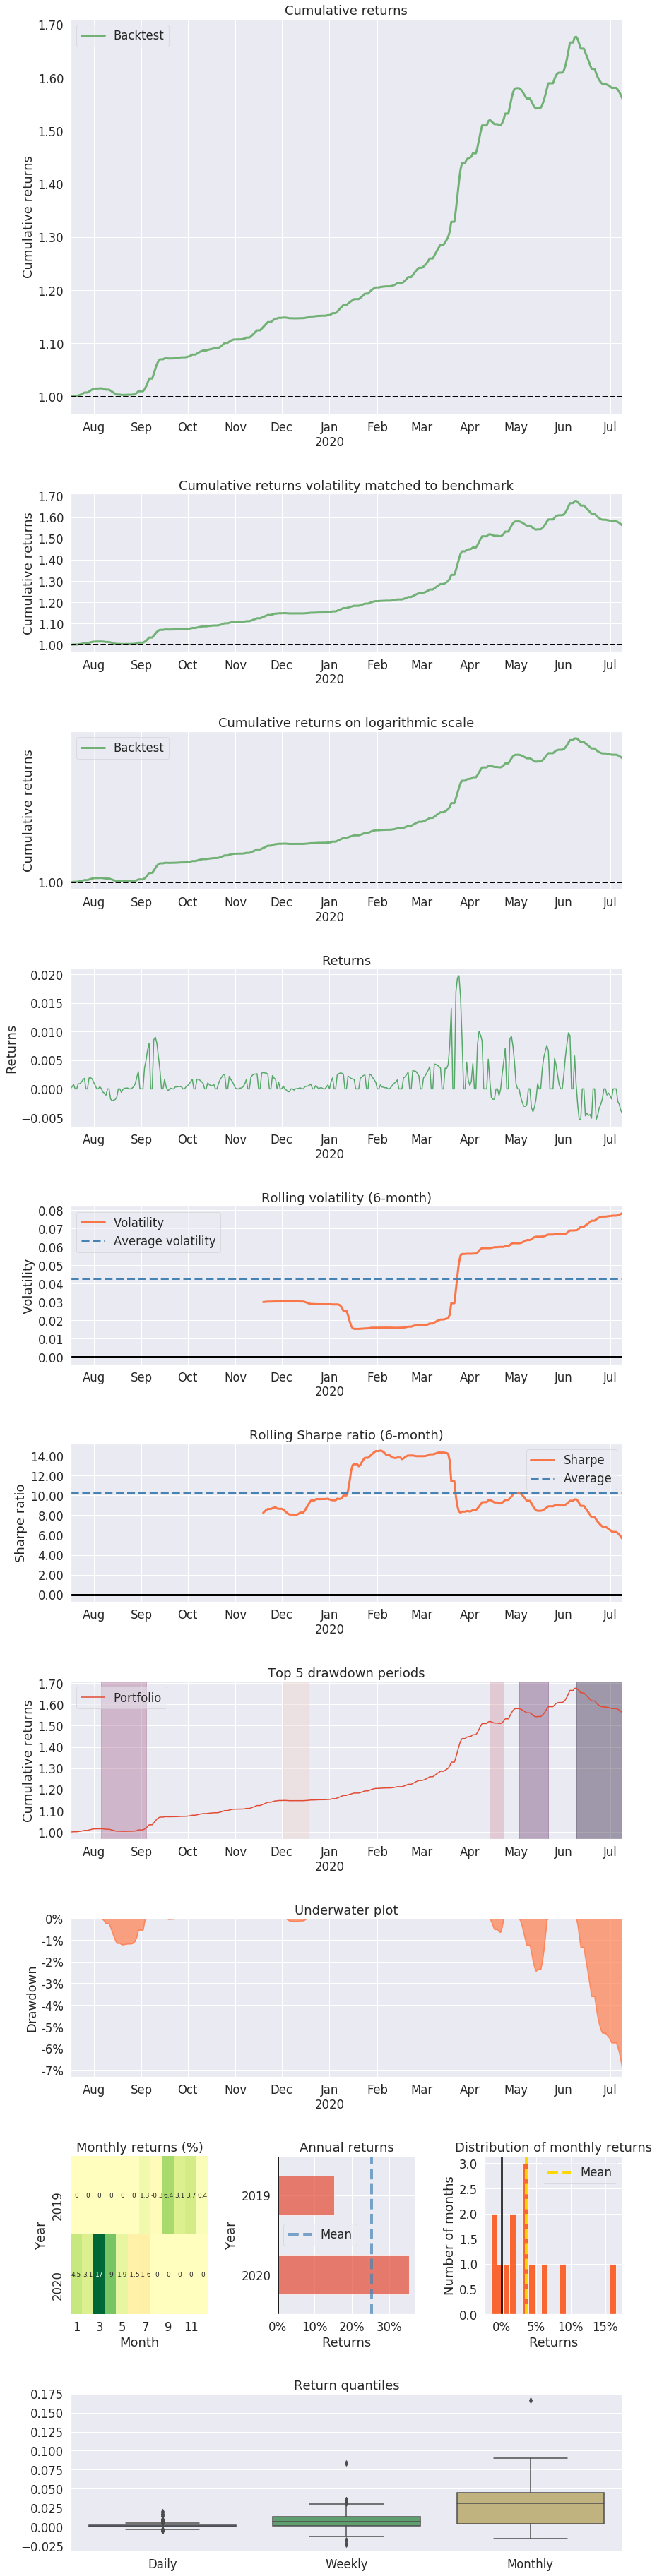

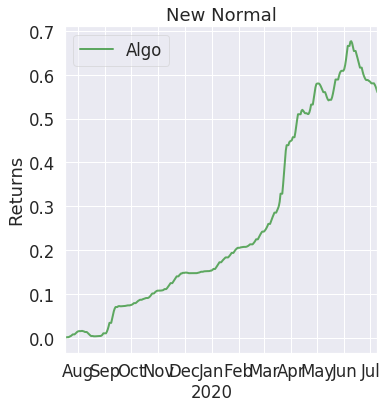

In [92]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min        max      mean       std  count   count %
factor_quantile                                                           
1               -13.436123  -3.927804 -6.223646  1.307318   3645  4.021448
2                -8.178330  -2.835103 -4.659025  0.898933   3645  4.021448
3                -7.296771  -2.307019 -3.898556  0.821528   3645  4.021448
4                -6.301523  -1.878921 -3.326971  0.768883   3645  4.021448
5                -5.705219  -1.505889 -2.848852  0.712775   3645  4.021448
6                -4.915113  -1.205743 -2.416705  0.632865   3645  4.021448
7                -4.422460  -0.928382 -2.024051  0.553324   3645  4.021448
8                -4.073920  -0.635649 -1.646464  0.482091   3645  4.021448
9                -3.588453  -0.417731 -1.303800  0.426743   3402  3.753351
10               -2.953836  -0.167068 -0.971362  0.386710   3645  4.021448
11               -2.455560   0.243441 -0.627149  0.368402   3645  4.021448
12               -1.842411   0.717522 -0.283460  0.360860   3645  4.021448
13               -1.452579   1.198466  0.068232  0.387339   3645  4.021448
14               -0.889444   1.590002  0.407971  0.417451   3645  4.021448
15               -0.432680   2.043439  0.750961  0.452221   3645  4.021448
16               -0.056988   2.412823  1.101895  0.485508   3645  4.021448
17                0.467863   2.954454  1.455013  0.502613   3402  3.753351
18                0.849480   3.478521  1.829428  0.517806   3645  4.021448
19                1.291576   4.334312  2.253349  0.547744   3645  4.021448
20                1.727794   4.833504  2.720696  0.598084   3645  4.021448
21                2.077793   5.562094  3.228440  0.651422   3645  4.021448
22                2.552212   6.412640  3.776835  0.705900   3645  4.021448
23                3.093892   7.327747  4.439956  0.802330   3645  4.021448
24                3.584173   8.100174  5.246060  0.899901   3645  4.021448
25                4.277111  14.647689  6.910925  1.507997   3645  4.021448

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.557    0.540    0.511
beta                                             0.230    0.195    0.047
Mean Period Wise Return Top Quantile (bps)     143.381  136.130  116.813
Mean Period Wise Return Bottom Quantile (bps)  -95.097  -93.827  -80.522
Mean Period Wise Spread (bps)                  238.478  228.758  195.628

<Figure size 1800x1080 with 0 Axes>

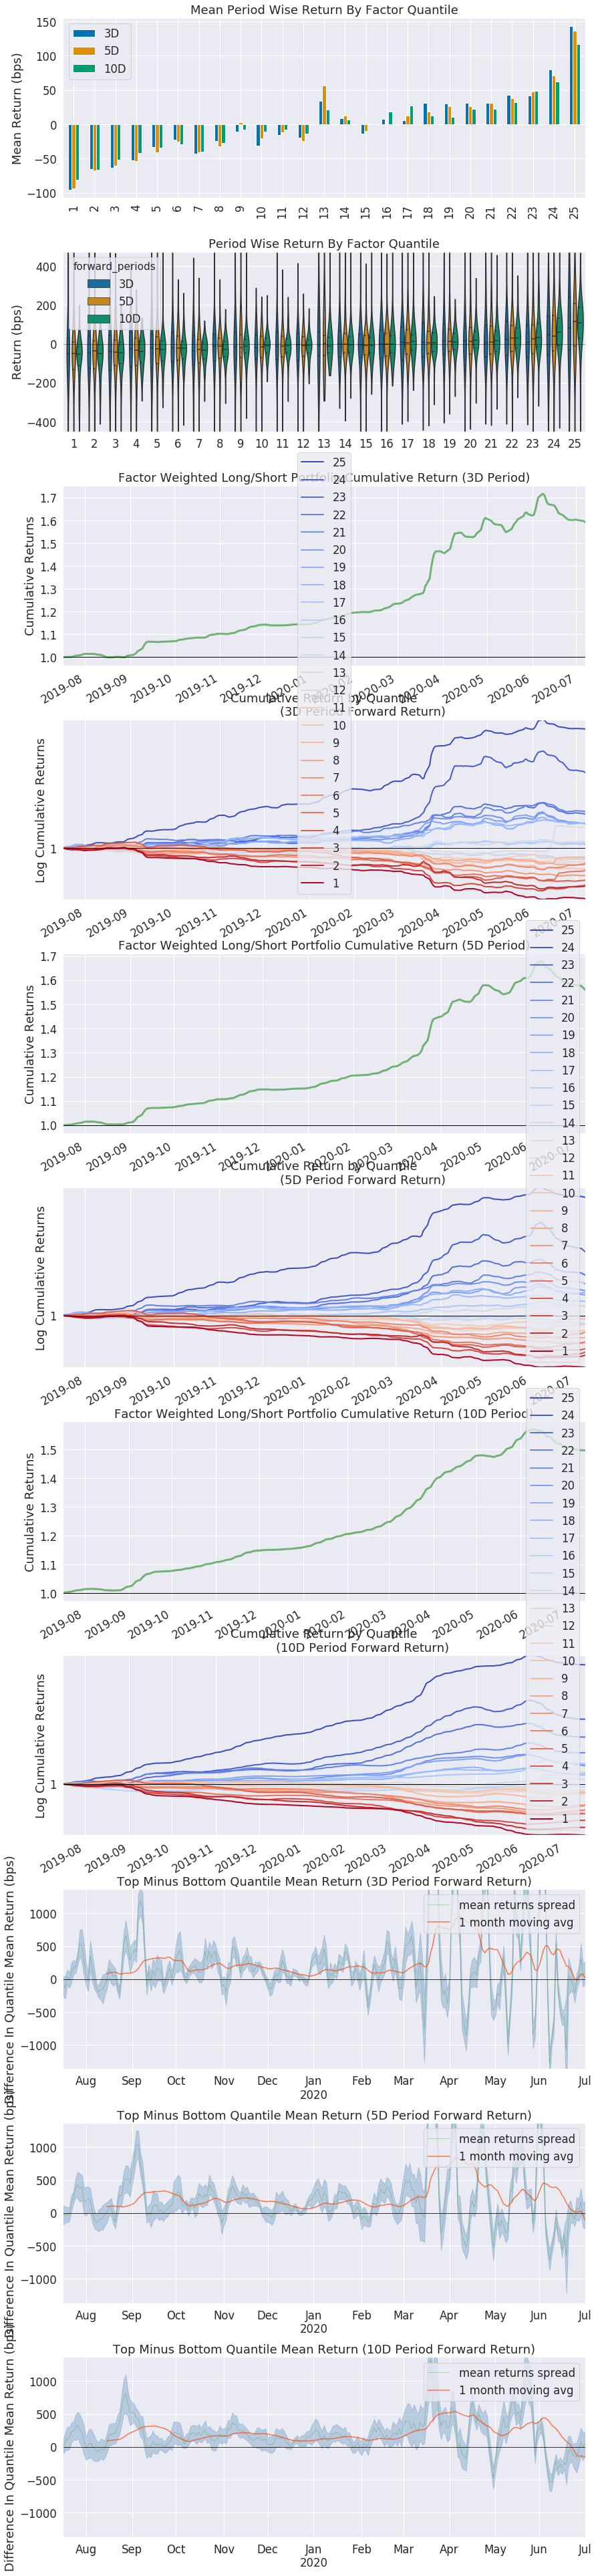

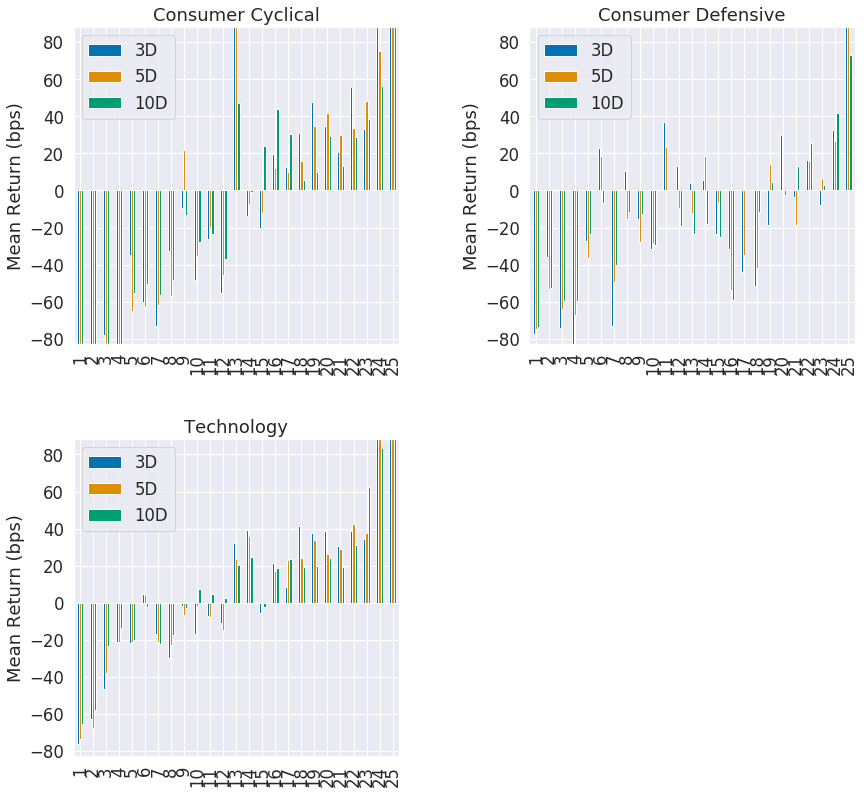

Information Analysis


3D     5D    10D
IC Mean           0.066  0.088  0.138
IC Std.           0.208  0.220  0.225
Risk-Adjusted IC  0.319  0.402  0.615
t-stat(IC)        4.967  6.268  9.584
p-value(IC)       0.000  0.000  0.000
IC Skew          -0.015 -0.054 -0.551
IC Kurtosis       0.147 -0.048  0.025

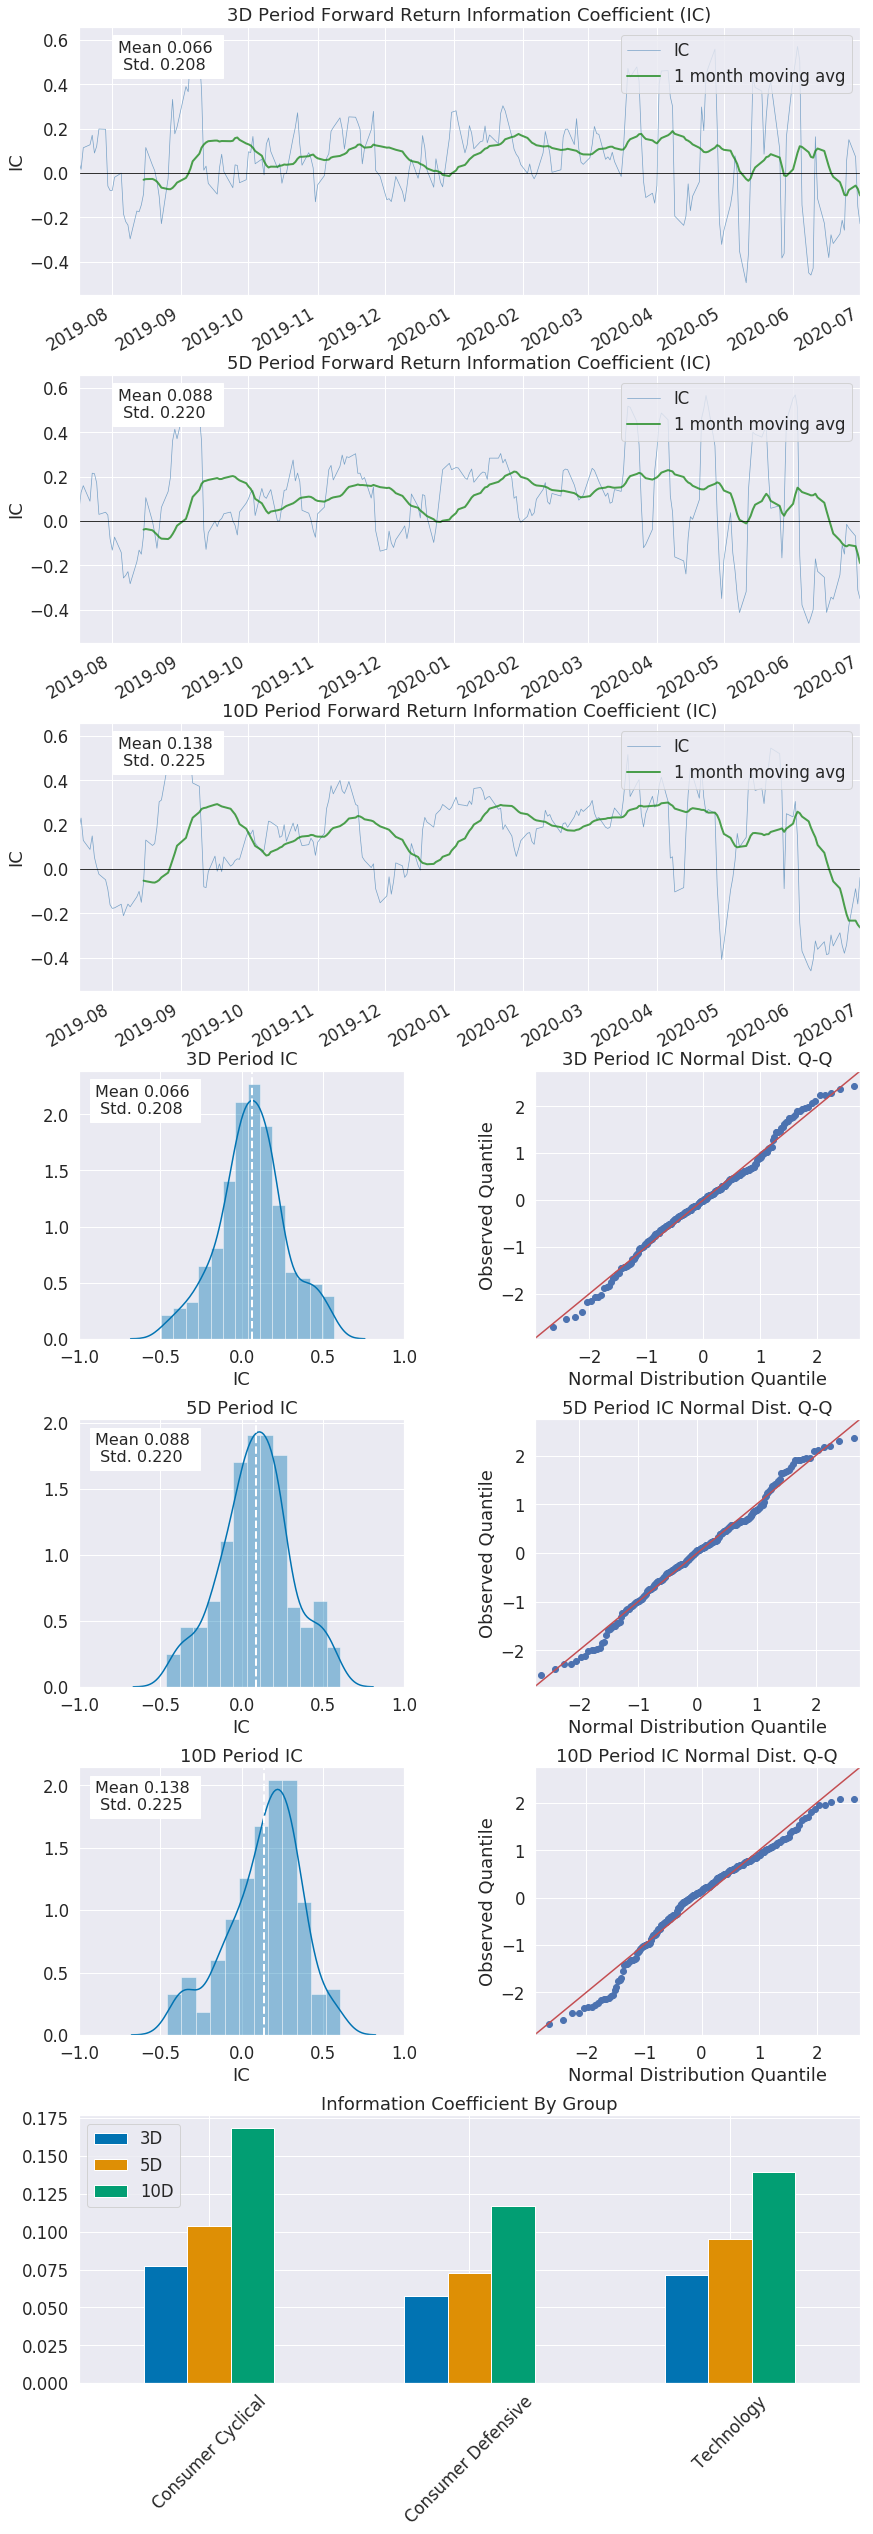

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover    0.475  0.224  0.324
Quantile 2 Mean Turnover    0.756  0.495  0.624
Quantile 3 Mean Turnover    0.819  0.600  0.714
Quantile 4 Mean Turnover    0.854  0.652  0.762
Quantile 5 Mean Turnover    0.869  0.718  0.805
Quantile 6 Mean Turnover    0.875  0.730  0.818
Quantile 7 Mean Turnover    0.896  0.754  0.826
Quantile 8 Mean Turnover    0.895  0.767  0.840
Quantile 9 Mean Turnover    0.918  0.787  0.857
Quantile 10 Mean Turnover   0.910  0.791  0.845
Quantile 11 Mean Turnover   0.903  0.784  0.855
Quantile 12 Mean Turnover   0.908  0.786  0.858
Quantile 13 Mean Turnover   0.913  0.793  0.871
Quantile 14 Mean Turnover   0.917  0.794  0.865
Quantile 15 Mean Turnover   0.897  0.792  0.854
Quantile 16 Mean Turnover   0.907  0.771  0.859
Quantile 17 Mean Turnover   0.911  0.787  0.860
Quantile 18 Mean Turnover   0.894  0.755  0.838
Quantile 19 Mean Turnover   0.887  0.739  0.822
Quantile 20 Mean Turnover   0.888  0.720  0.805
Quantile 21 Mean Turnover   0.872  0.717  0.808
Quantile 22 Mean Turnover   0.859  0.674  0.768
Quantile 23 Mean Turnover   0.837  0.618  0.741
Quantile 24 Mean Turnover   0.758  0.511  0.641
Quantile 25 Mean Turnover   0.516  0.240  0.349

3D     5D    10D
Mean Factor Rank Autocorrelation  0.963  0.923  0.828

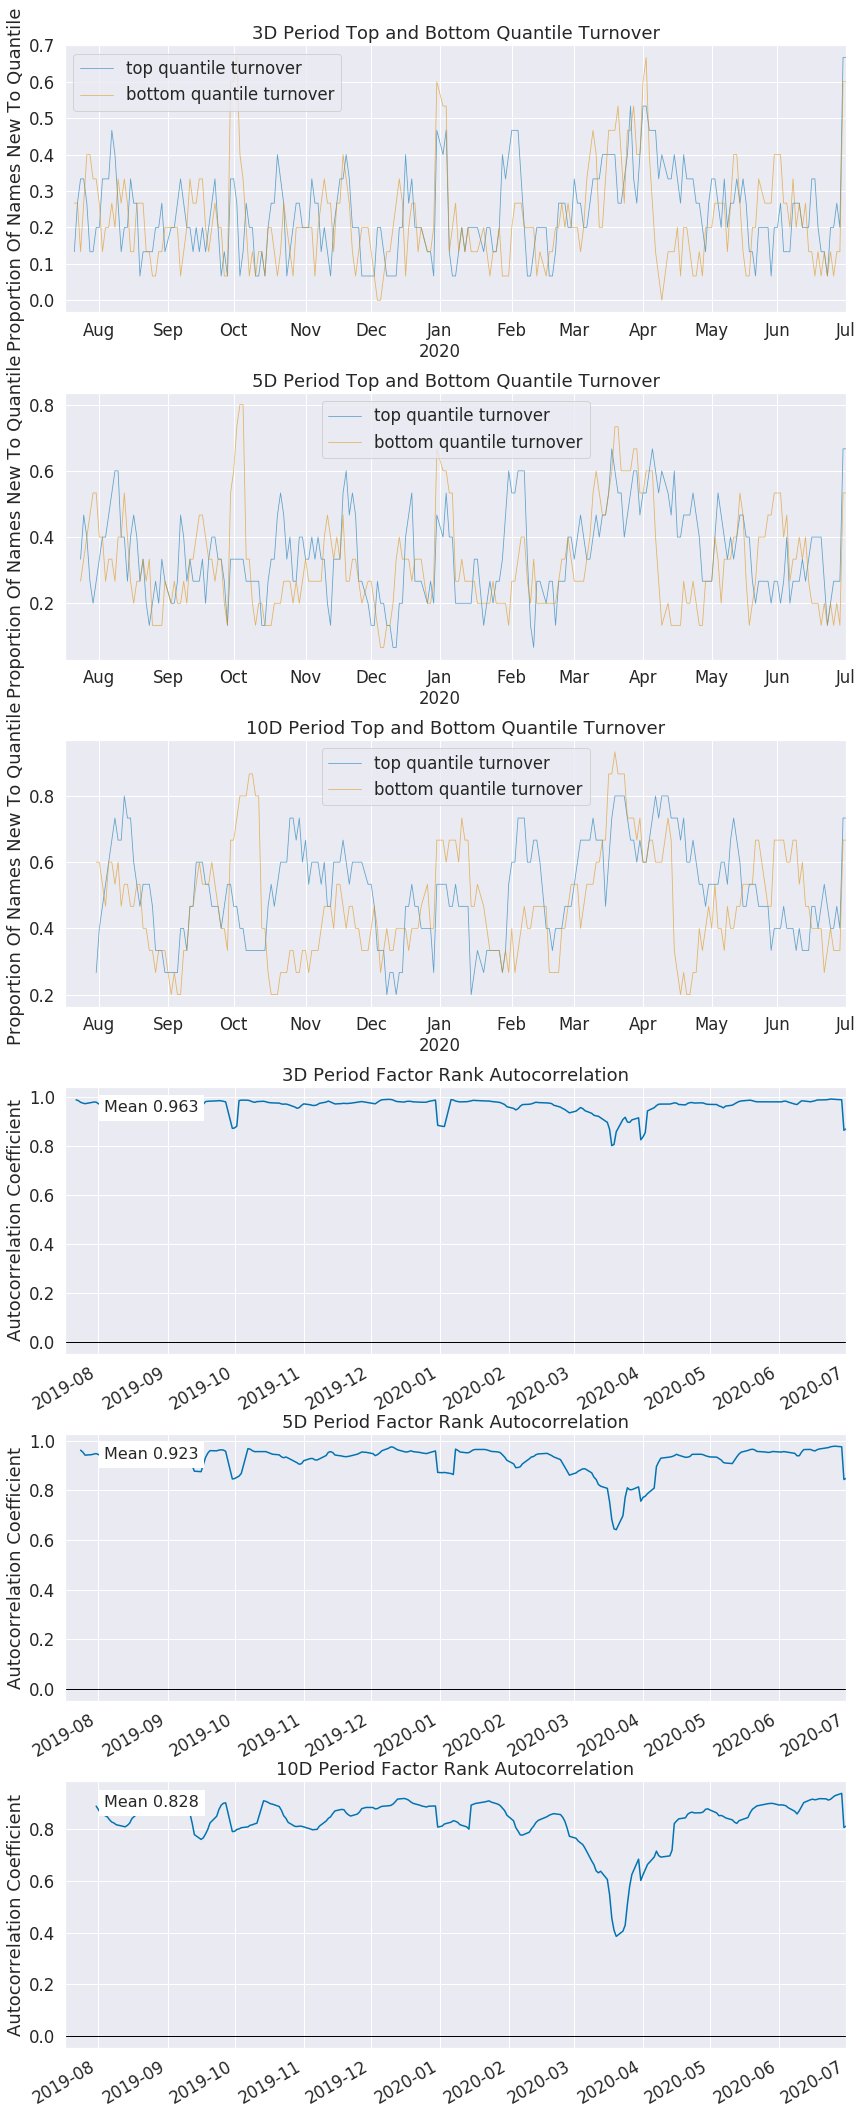

In [93]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

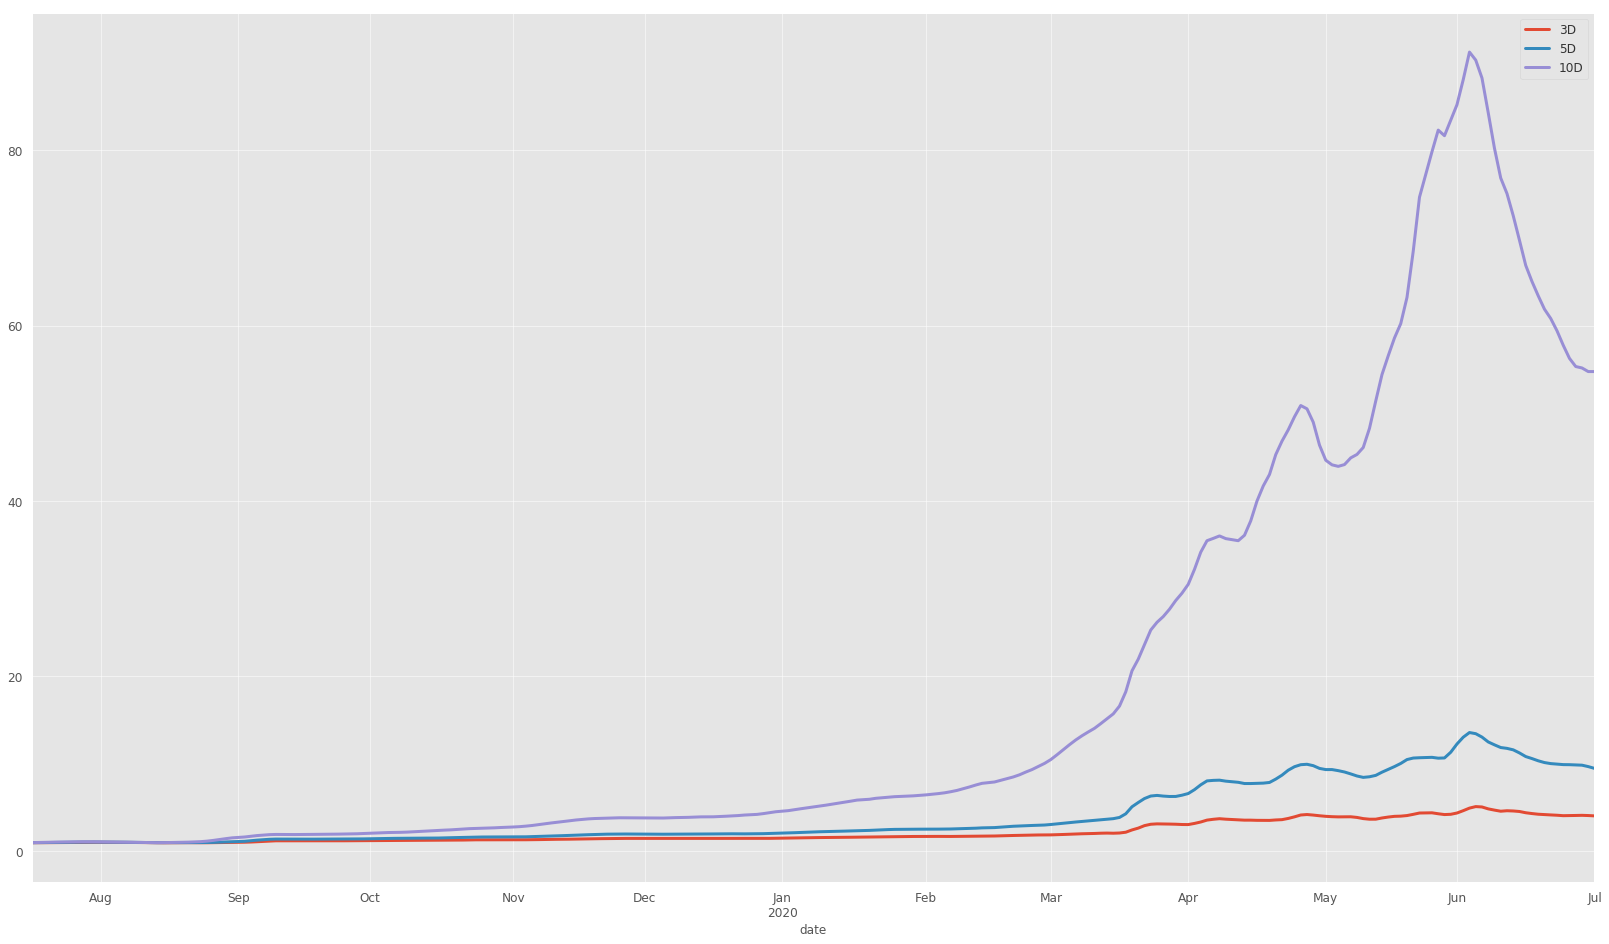

In [94]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data)

(1+ls_factor_returns).cumprod().plot(lw=3);

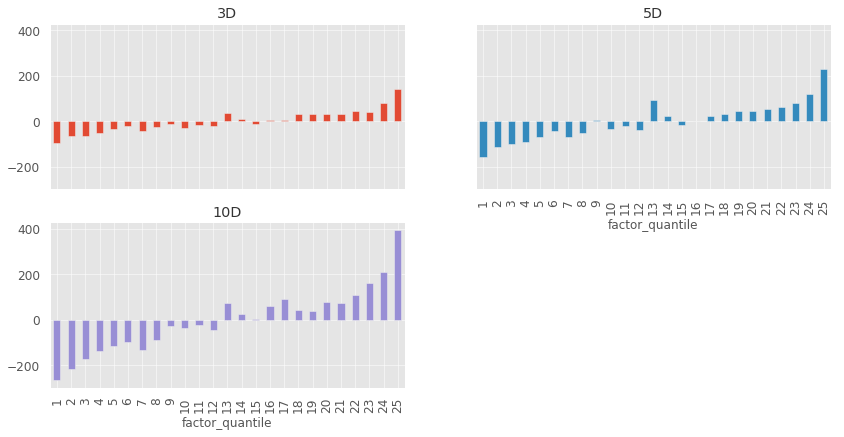

In [95]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

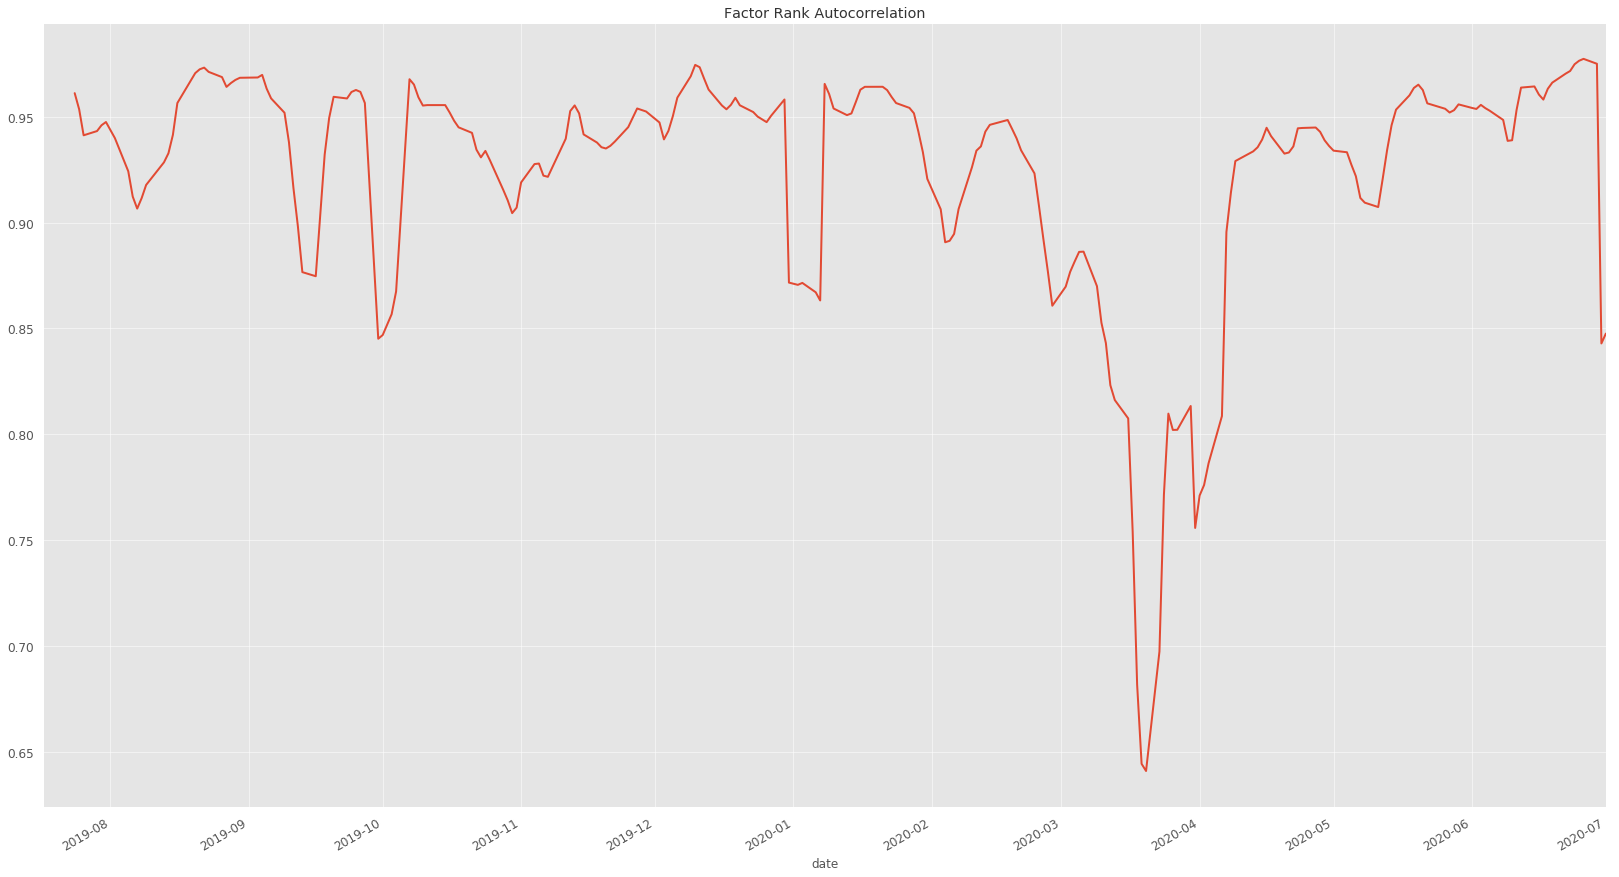

In [96]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [97]:
ls_FRA.mean()

0.9229432110478388

In [98]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

3D      5.09
5D      6.38
10D    10.47
dtype: float64

# 7 -  Risk analysis for equal weights

In [99]:
assets = all_factors.index.levels[1]

In [100]:
all_weights = pd.DataFrame(np.repeat(1/len(assets), len(assets)), assets)

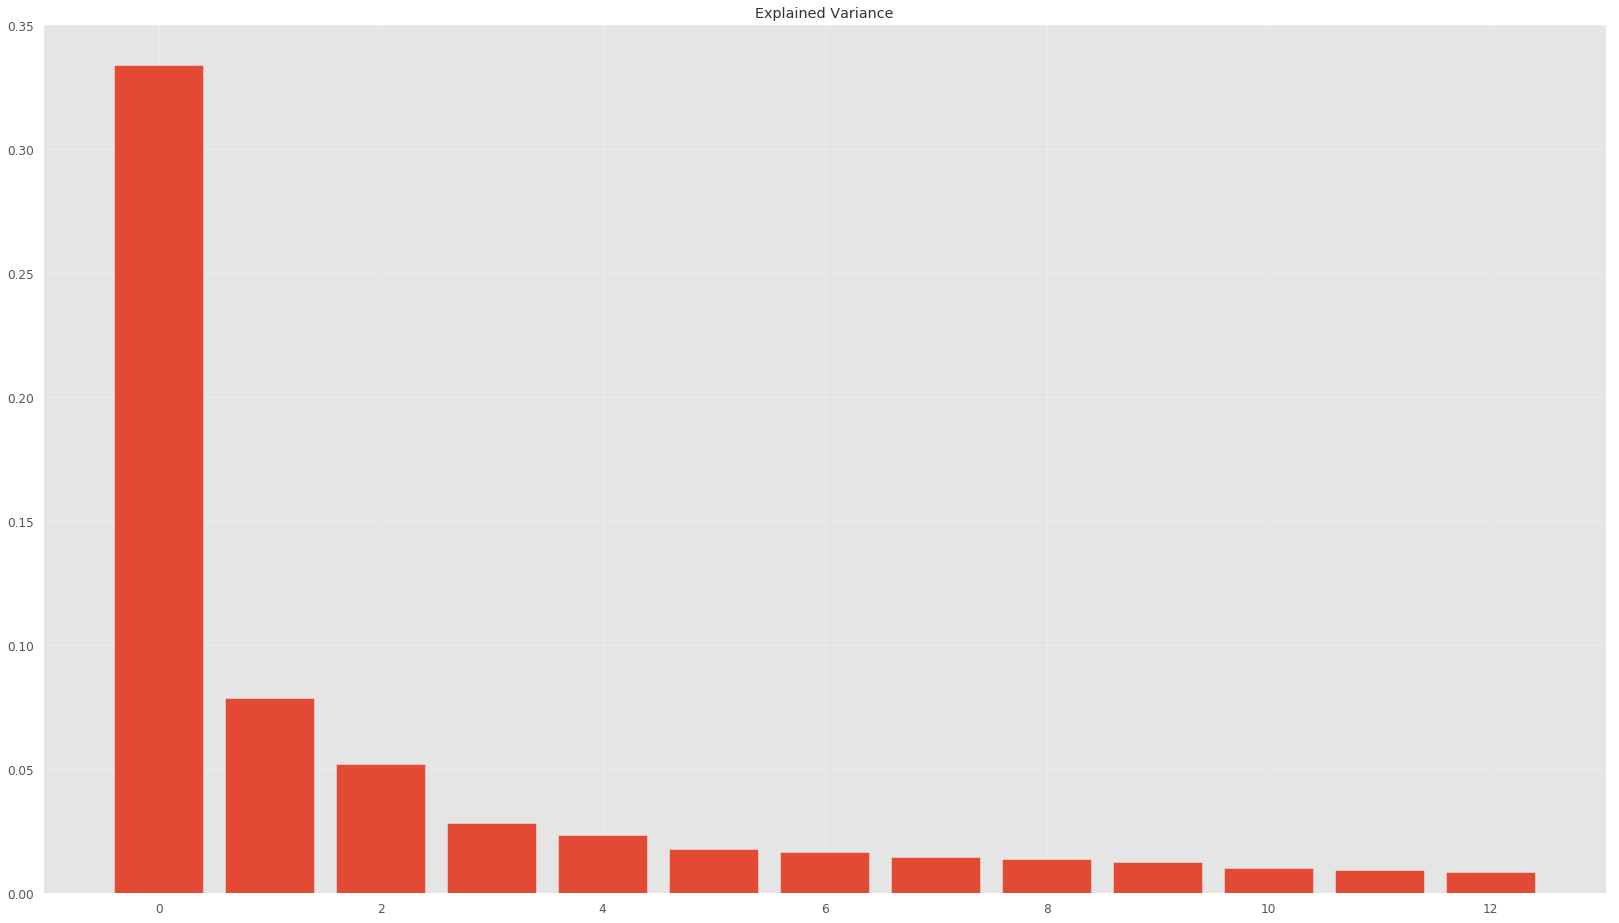

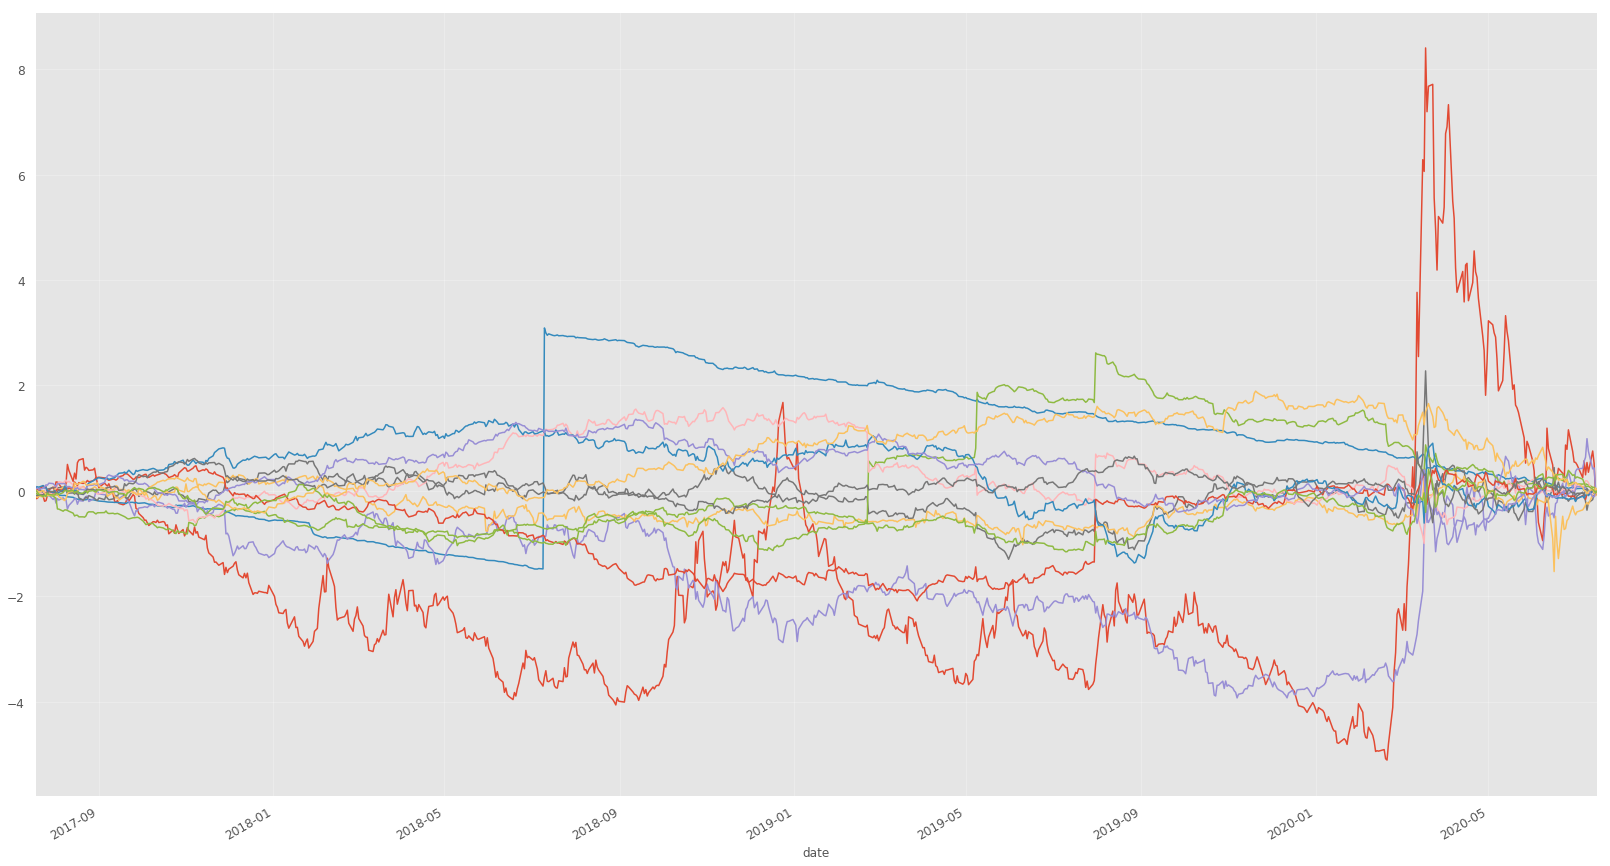

In [101]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[assets],num_factor_exposures=13,weights=all_weights)

In [102]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 26.71 %


# 8 - Integrating factor data to optimzer

In [103]:
optimal = pd.DataFrame(index = all_factors.index.levels[0], columns = all_factors.index.levels[1])
for date in all_factors.index.levels[0]:
    
    x = all_factors[['alpha_vector']].loc[date.date(),:]
    optimal.loc[date] = risk_model\
                          .OptimalHoldingsRegularization(lambda_reg = lambda_reg,
                                                         risk_cap = risk_cap).find(
                                                            x, 
                                                            Risk_Model['factor_betas'], 
                                                            Risk_Model['factor_cov_matrix'], 
                                                            Risk_Model['idiosyncratic_var_vector']).values.flatten()
    

    
optimal = optimal.astype(np.float)
optimal_stacked = optimal.stack().to_frame('optimal_weights')

In [104]:
assert optimal_stacked.shape[0] == vec.shape[0]

## Quantilize data

In [105]:
quantile_optimal_stacked = pd.DataFrame(index = optimal_stacked.index, 
                                        columns = ['optimal_weights','quantile','sector'])
qunatiles = np.linspace(0,1,qunatile_portions+1)
labels = [i+1 for i in range(len(qunatiles)-1)]

for date in optimal_stacked.index.levels[0]:
    
    x = optimal_stacked['optimal_weights'].loc[date.date(),:]
    
    quantile_optimal_stacked.loc[date,'quantile'] = pd.qcut(x, qunatiles, 
                                                            labels = labels)
    
quantile_optimal_stacked.loc[:,'optimal_weights'] = optimal_stacked['optimal_weights']
quantile_optimal_stacked.loc[:,'sector'] = vec['sector']

In [106]:
quantile_optimal_stacked.shape

(94369, 3)

In [107]:
try:
    q_list = []
    for i in qunatile_to_analysis:
        q_list.append((quantile_optimal_stacked['quantile'] == i))

    df_merge = q_list[0]
    for df in q_list[1:]:       
        df_merge = df_merge ^ df
    
    q_final_vector = quantile_optimal_stacked[df_merge]
    
except:
    
    q_final_vector = quantile_optimal_stacked

In [108]:
remaining_quantiles = list(set(q_final_vector.loc[:,'quantile'].values))

In [109]:
rows = q_final_vector.shape[0]

## Sector Selection

In [110]:
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[-1]))

    for i in drop_short_sec:
        drop_rows_list.append((q_final_vector.sector == i) & (q_final_vector['quantile'] == labels[0]))

    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    final_vector = q_final_vector[~df_merge]
    sectors = final_vector['sector']
    
    assert list(final_vector[(final_vector['quantile'] == labels[-1]) & (final_vector['sector'] == drop_long_sec[0])].values) == []
    assert list(final_vector[(final_vector['quantile'] == labels[0]) & (final_vector['sector'] == drop_short_sec[0])].values) == []

except:
    final_vector = q_final_vector
    sectors = final_vector['sector']

In [111]:
print ('{} rows dropped from final vector'.format(rows - final_vector.shape[0]))

0 rows dropped from final vector


## Balancing to long/short leverage target

In [112]:
for date in final_vector.index.levels[0]:
    
    long_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0].sum())
    short_balance = np.abs(final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0].sum())
    
    long_ratio = percent_long_leverage_target / long_balance
    short_ratio = percent_short_leverage_target / short_balance

    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']>0] * long_ratio
    final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] = final_vector.loc[date,'optimal_weights'][final_vector.loc[date,'optimal_weights']<0] * short_ratio

# 9 - Optimized factor analysis

## 9 - 1 - Creating clean factor data

In [113]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = final_vector['optimal_weights'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = len(remaining_quantiles),
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


In [114]:
rows = factor_data.shape[0]

In [115]:
# Sector Selection
try:
    drop_rows_list = []
    for i in drop_long_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 2))

    for i in drop_short_sec:
        drop_rows_list.append((factor_data.group == i) & (factor_data['factor_quantile'] == 1))
    
    if len(drop_rows_list) == 1:
        df_merge = drop_rows_list[0]
    else:
        df_merge = drop_rows_list[0]
        
        for df in drop_rows_list[1:]:       
            df_merge = df_merge ^ df

    factor_data = factor_data[~df_merge]
    sectors = factor_data['group']
    
except:
    
    sectors = factor_data['group']

In [116]:
print ('{} rows dropped from factor data'.format(rows - factor_data.shape[0]))

0 rows dropped from factor data


## 8 - 3 - Creating tear sheets 

In [117]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                   period= '{}D'.format(rebalance_period),
                                   capital=1,
                                   long_short=True,
                                   group_neutral=False,
                                   equal_weight=False,
                                   groups=sectors,
                                   #quantiles=[1,5],
                                   benchmark_period='{}D'.format(rebalance_period))

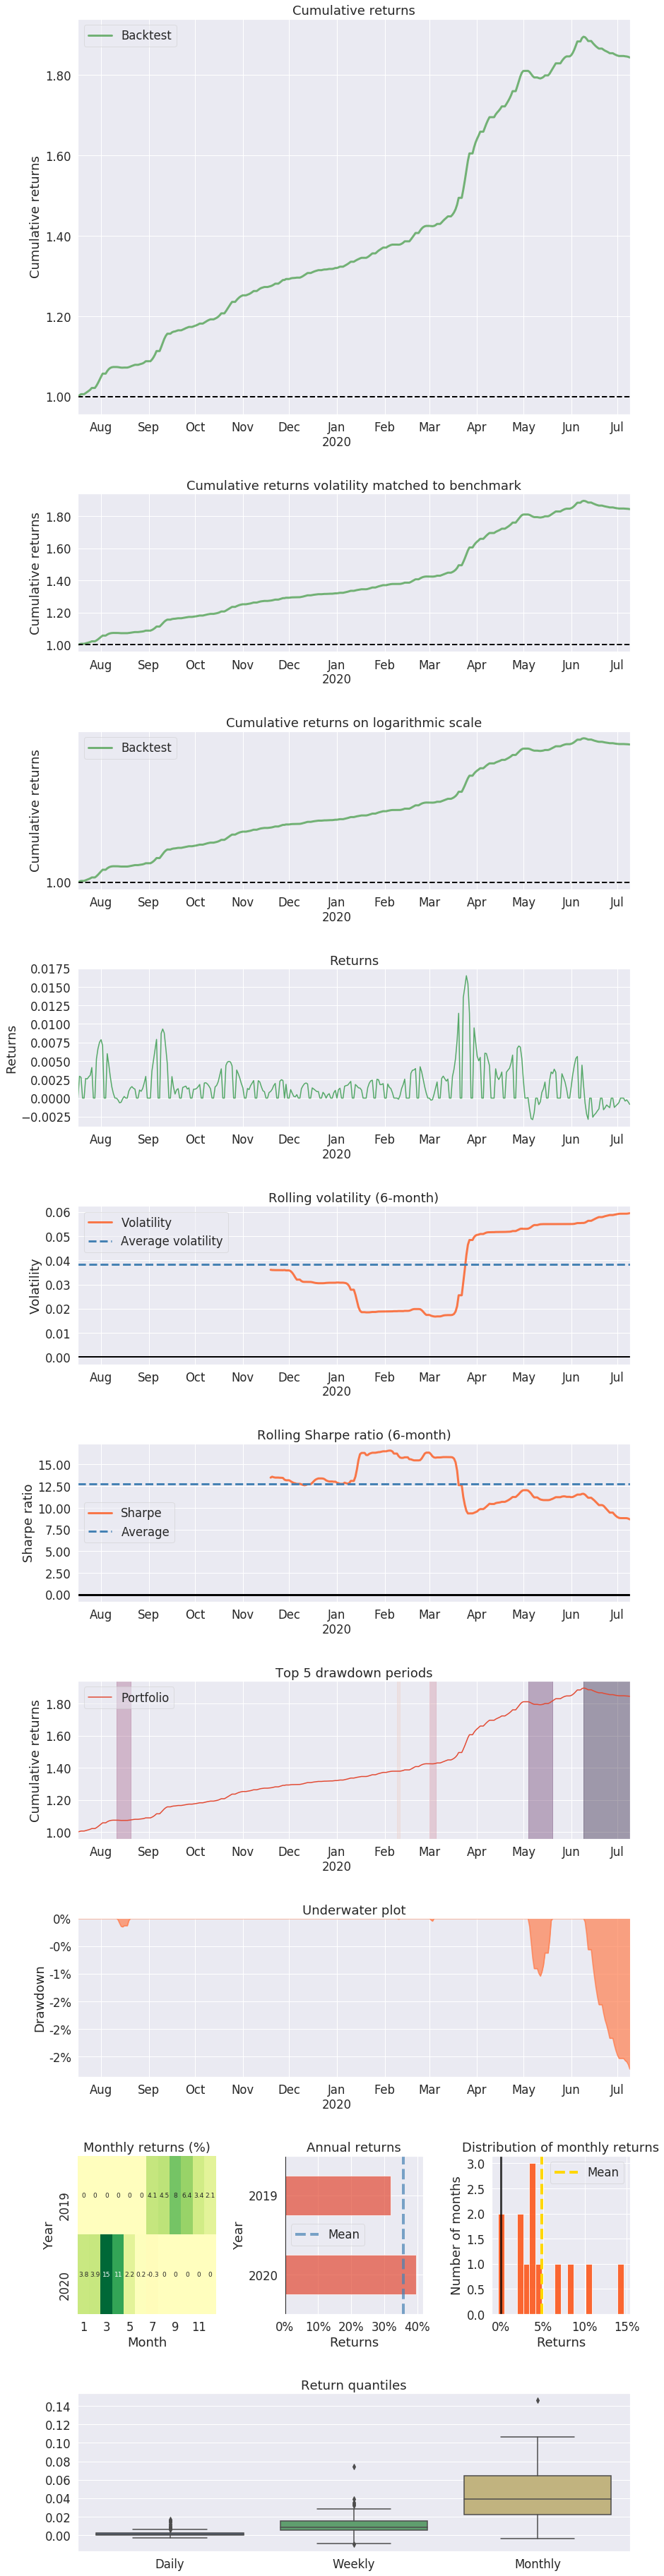

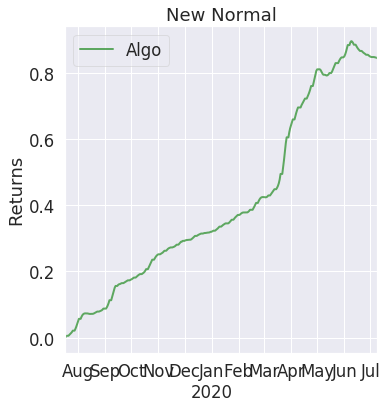

In [118]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min           max      mean       std  count  count %
factor_quantile                                                            
1               -0.159329 -2.282835e-09 -0.026667  0.021623   3645     50.0
2                0.004750  2.789084e-01  0.040000  0.032189   3645     50.0

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.827    0.835    0.717
beta                                             0.119    0.114    0.069
Mean Period Wise Return Top Quantile (bps)      76.787   74.792   63.090
Mean Period Wise Return Bottom Quantile (bps)  -76.787  -75.167  -64.033
Mean Period Wise Spread (bps)                  153.573  149.995  127.177

<Figure size 2016x1152 with 0 Axes>

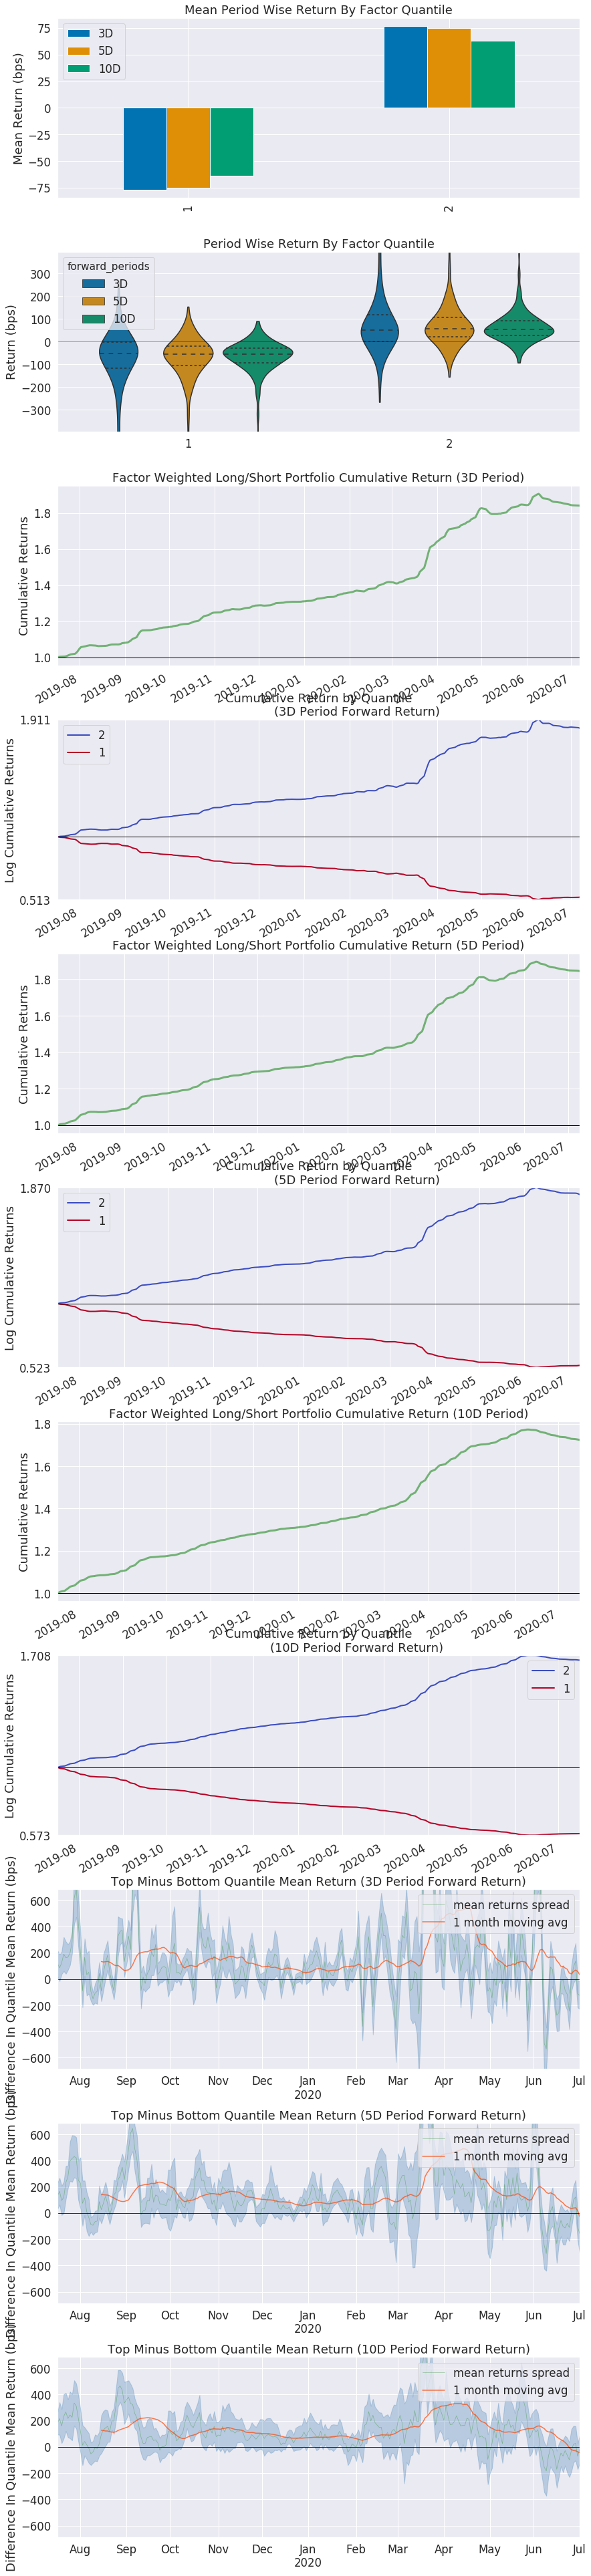

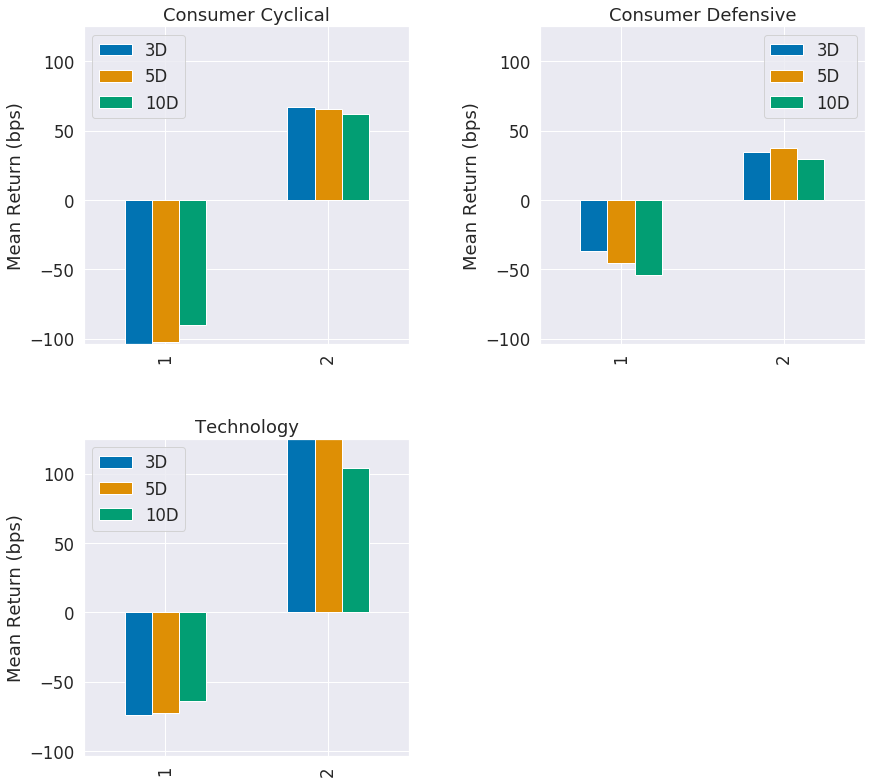

Information Analysis


3D      5D     10D
IC Mean           0.130   0.187   0.260
IC Std.           0.226   0.231   0.242
Risk-Adjusted IC  0.575   0.811   1.071
t-stat(IC)        8.963  12.636  16.697
p-value(IC)       0.000   0.000   0.000
IC Skew           0.042   0.072  -0.260
IC Kurtosis       0.119  -0.190  -0.303

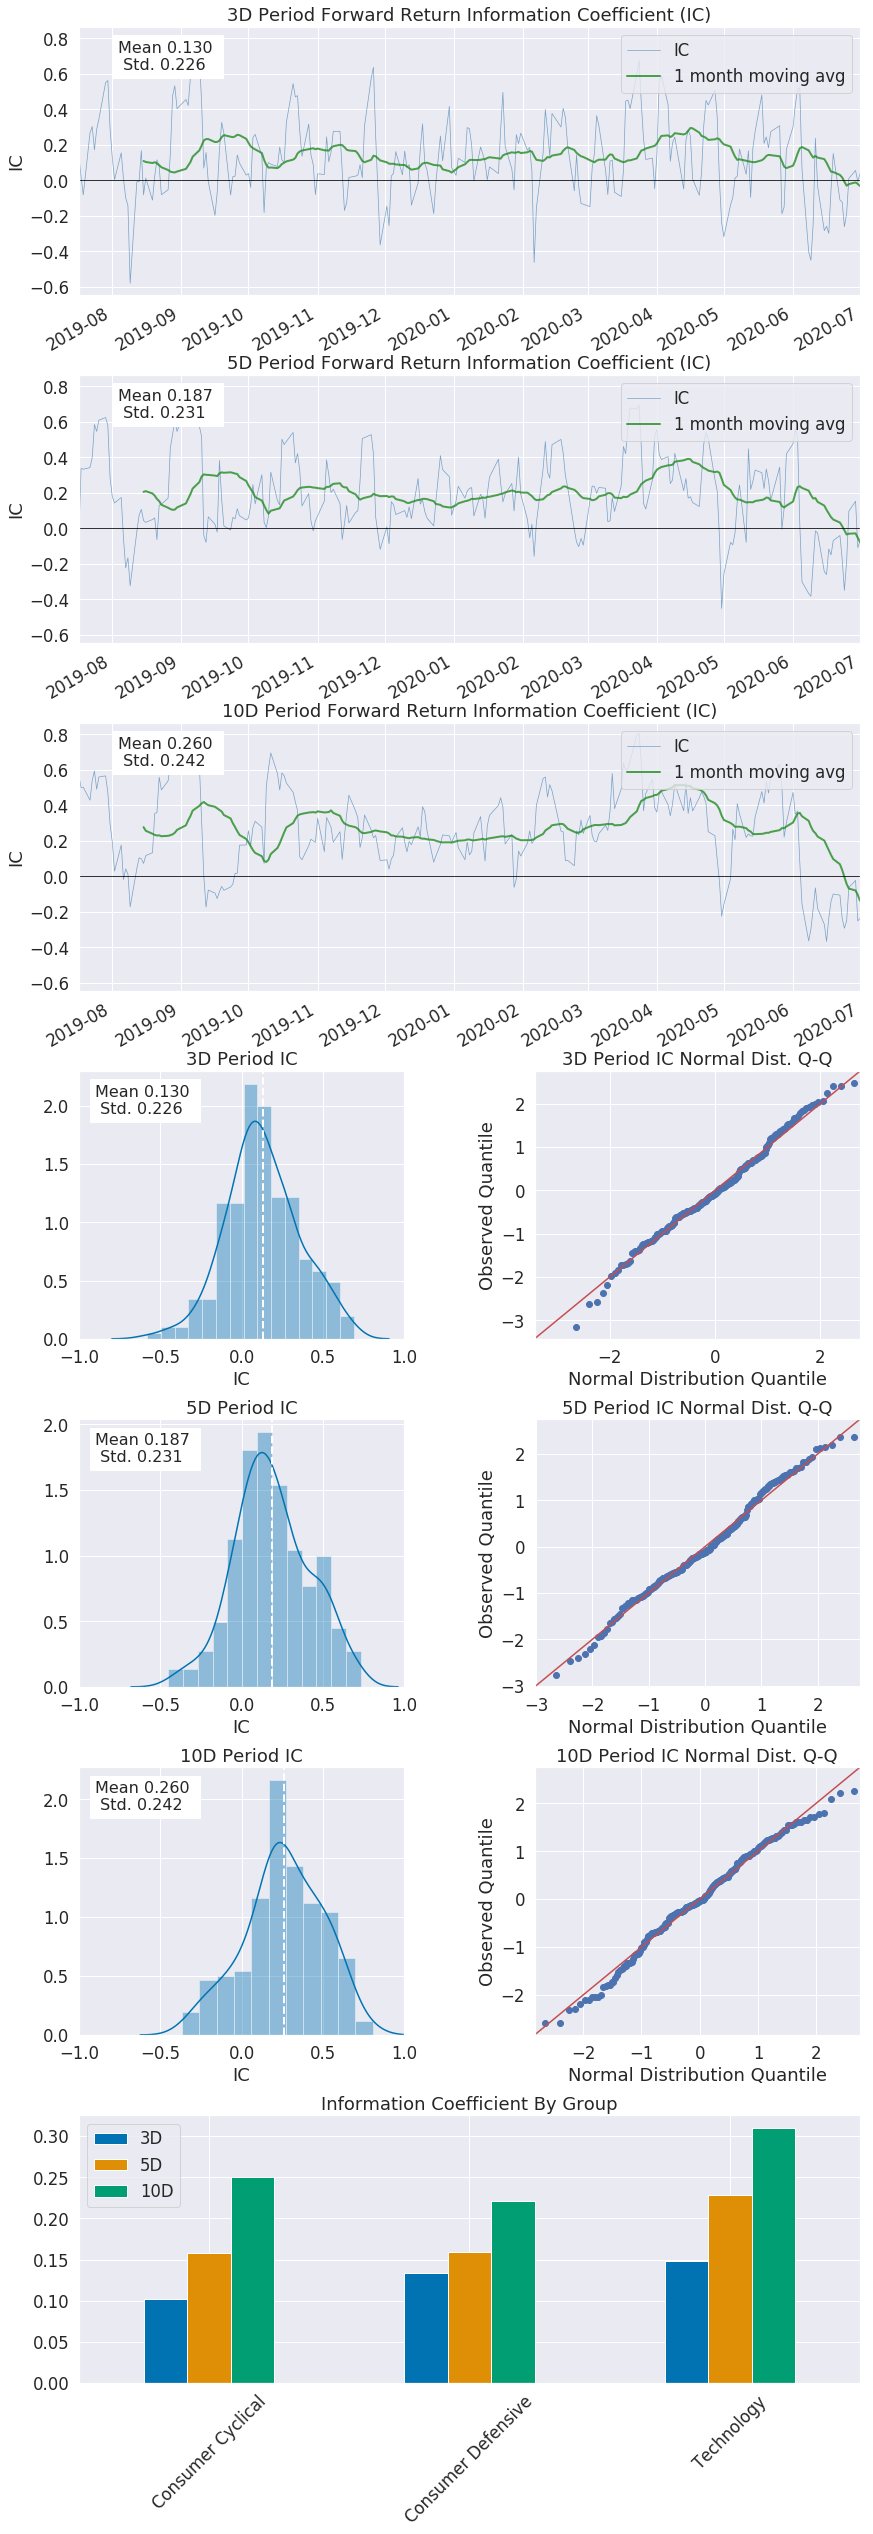

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover   0.513  0.237  0.346
Quantile 2 Mean Turnover   0.500  0.238  0.341

3D    5D    10D
Mean Factor Rank Autocorrelation  0.941  0.92  0.896

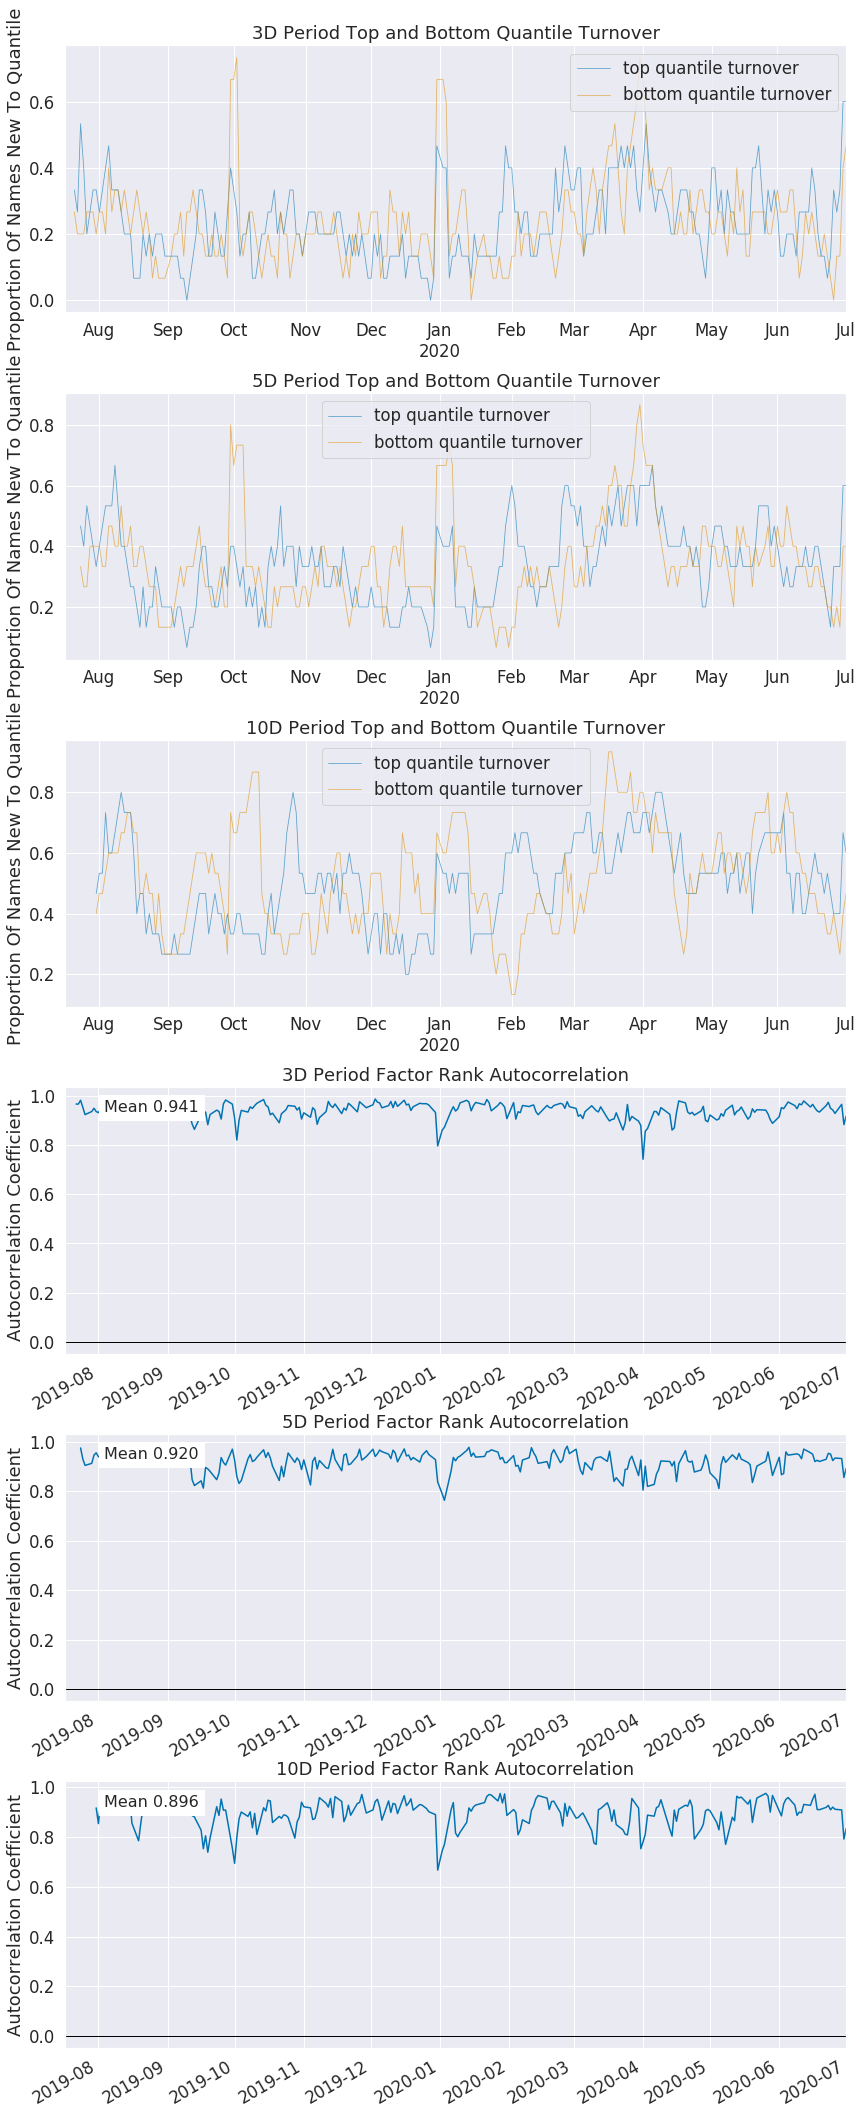

In [119]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

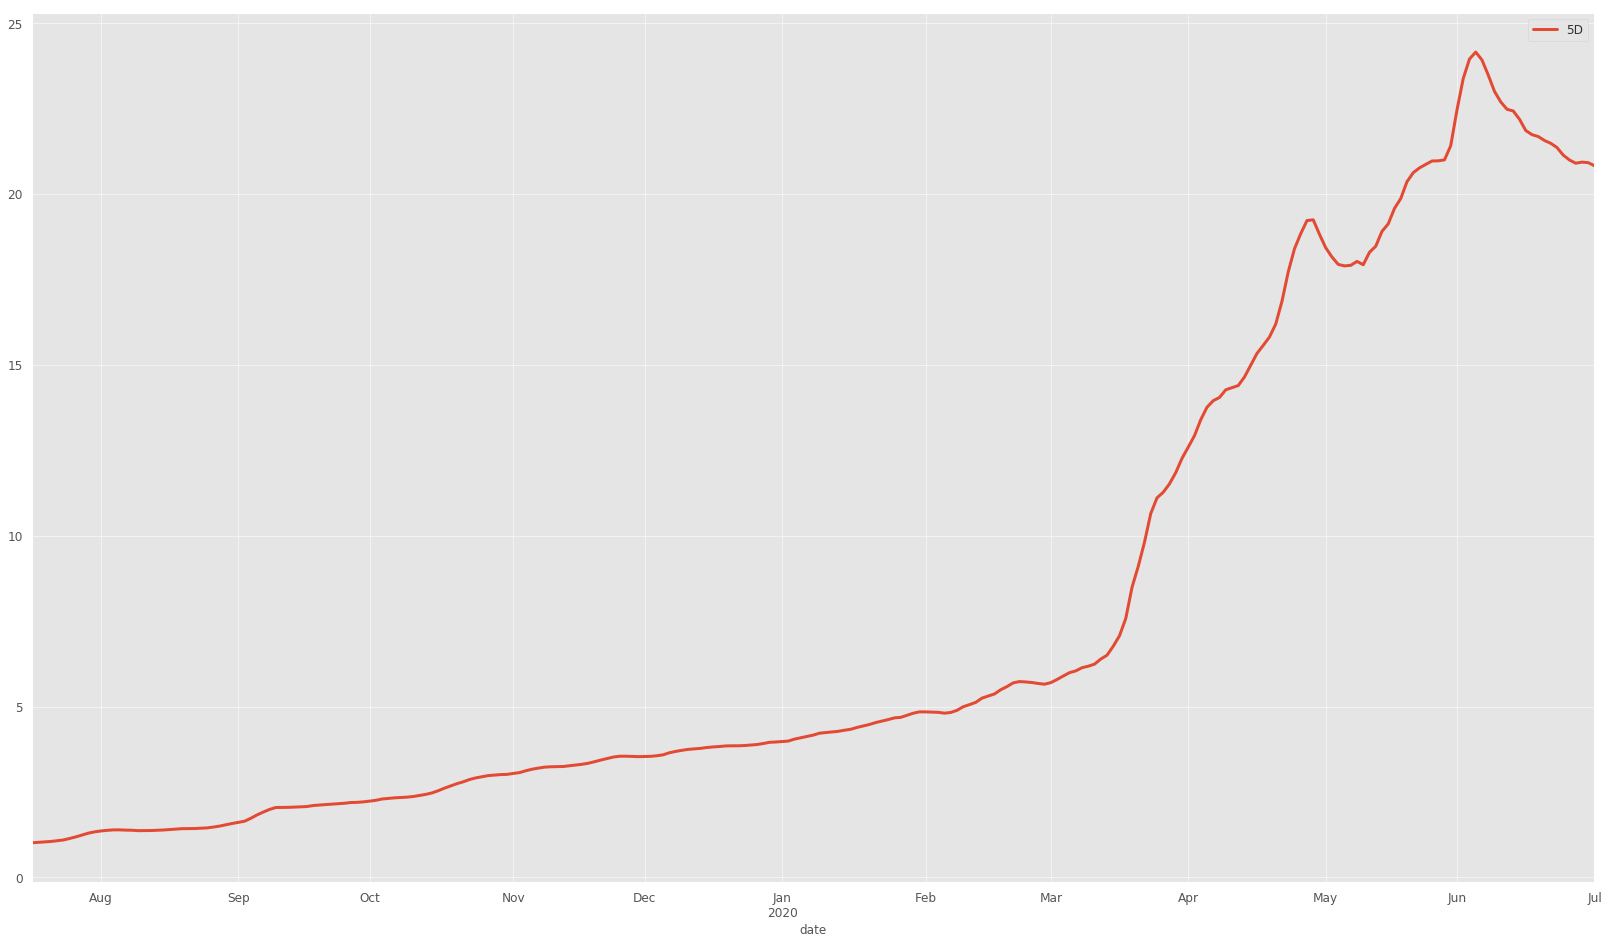

In [120]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data[['factor','5D']])

(1+ls_factor_returns).cumprod().plot(lw=3);

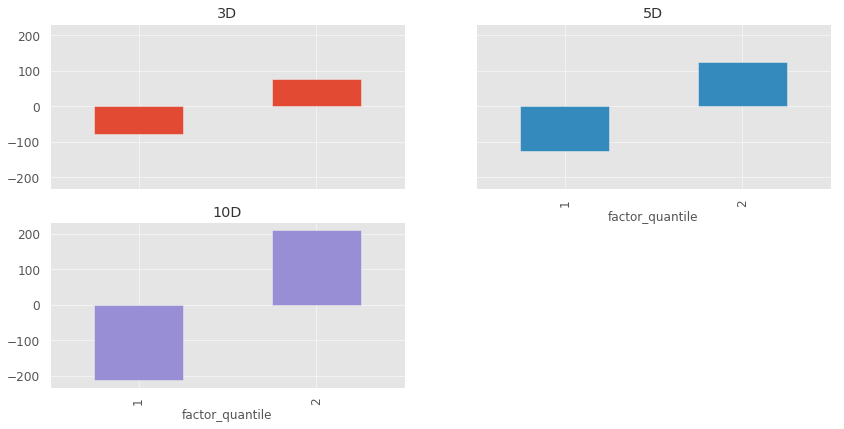

In [121]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

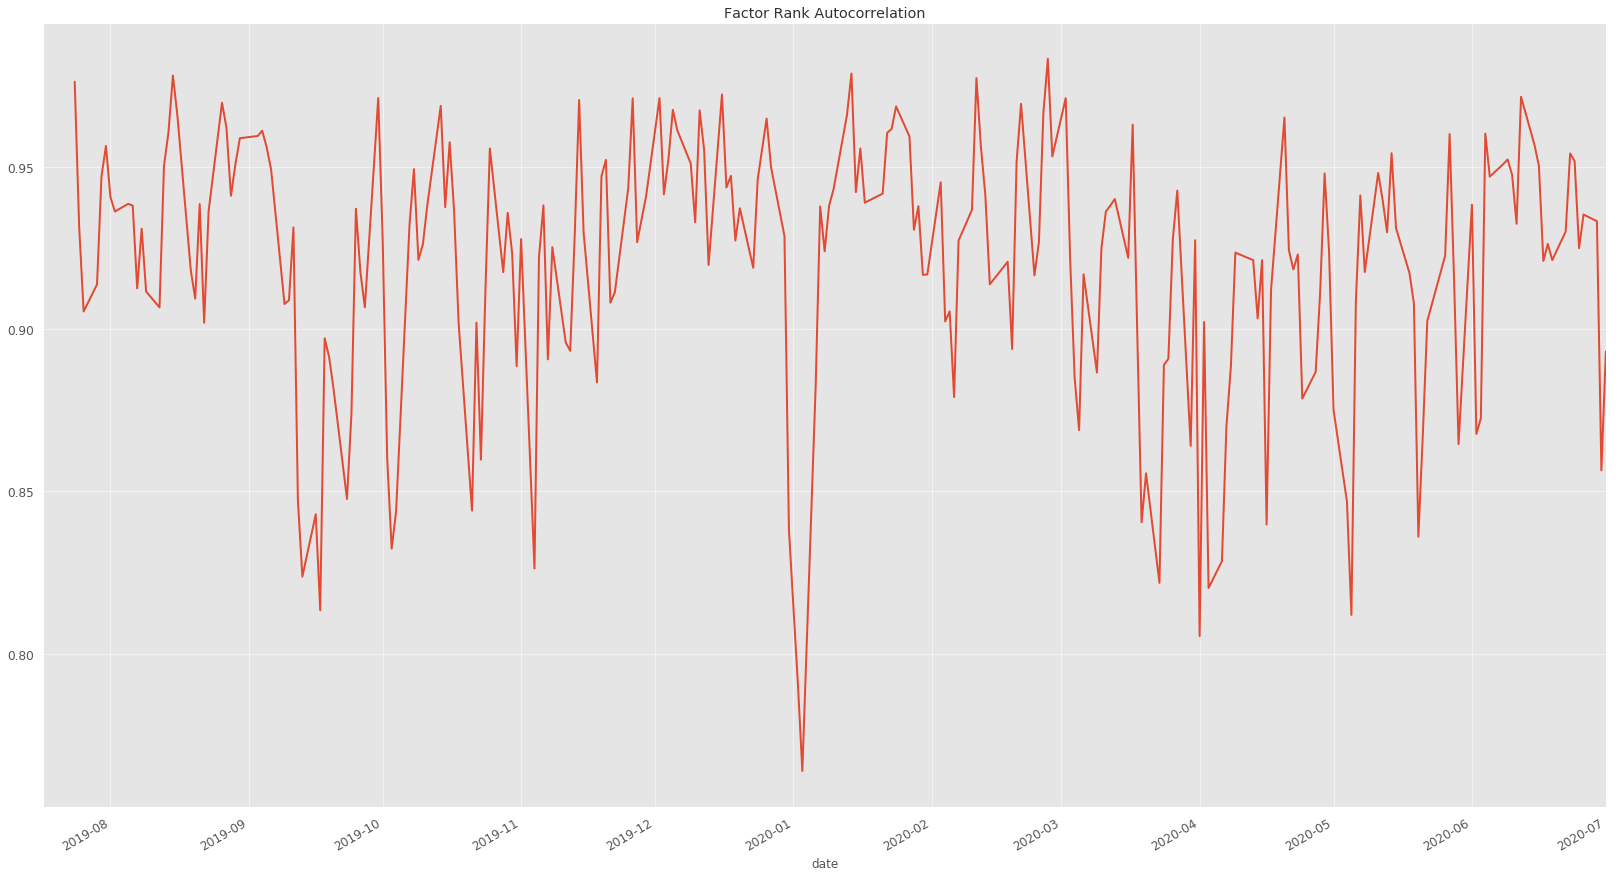

In [122]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [123]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

5D    11.58
dtype: float64

# 10 - Predicted Portfolio

In [124]:
optimal_weights_regularized = final_vector[['optimal_weights']].loc[final_vector.index.levels[0][-1]]

for 30 assets  with end date: 2020-07-16 00:00:00+00:00


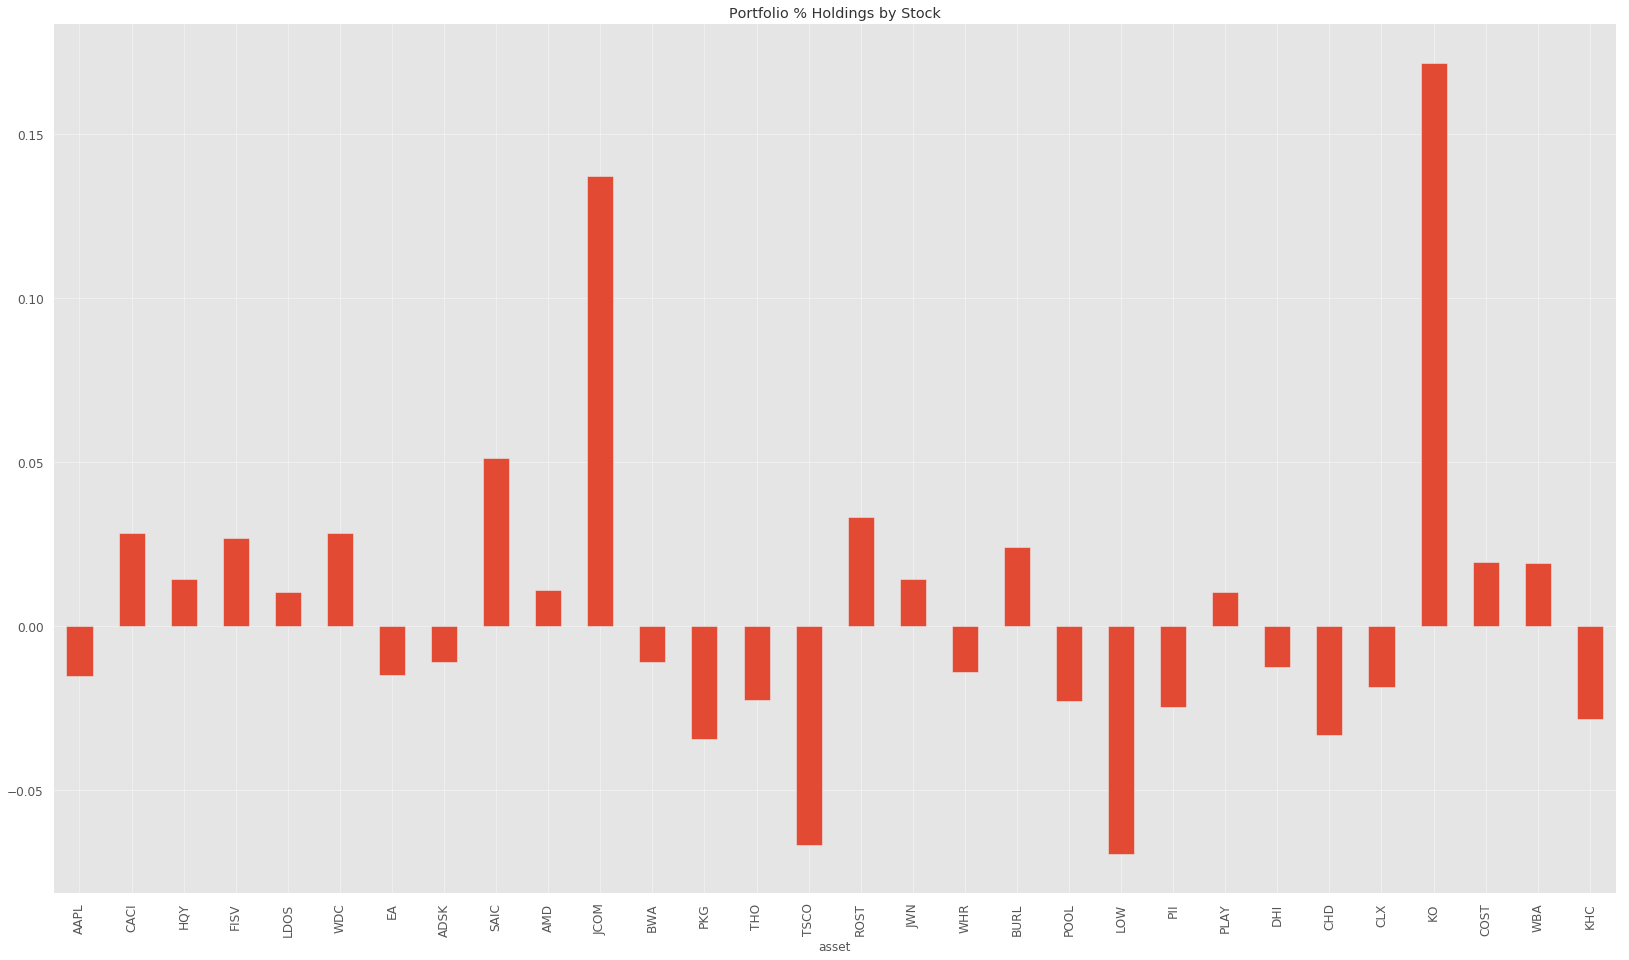

In [125]:
print ('for {} assets  with end date: {}'.format(len(optimal_weights_regularized.index),optimal.index[-1]))
optimal_weights_regularized.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.grid(alpha=0.8)

In [126]:
optimal_weights_regularized = pd.DataFrame(data = optimal_weights_regularized.values, 
                                           columns = ['optimal_weights'],
                                           index = optimal_weights_regularized.index)
optimal_weights_regularized.index.name = 'asset'

In [127]:
q5 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=False)[:len(optimal_weights_regularized.index)//5]
q1 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=True)[:len(optimal_weights_regularized.index)//5]

In [128]:
print (q5.iloc[0])
print (q1.iloc[0])

optimal_weights    0.171609
Name: KO, dtype: float64
optimal_weights   -0.069345
Name: LOW, dtype: float64


## 10 - 3 - Risk analysis with optimized weights

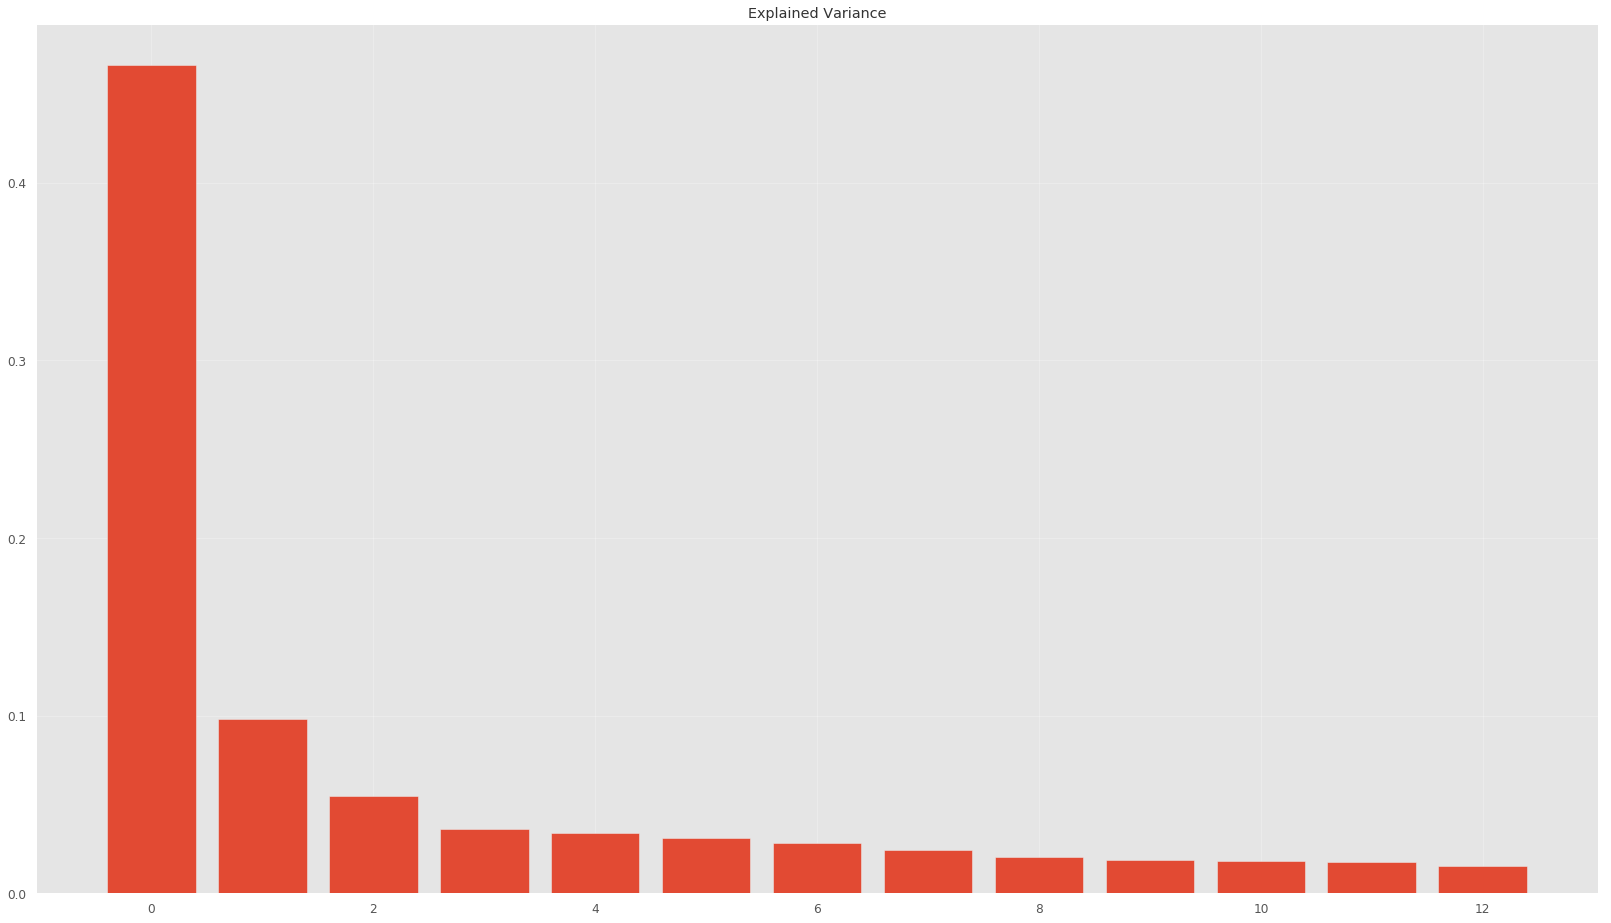

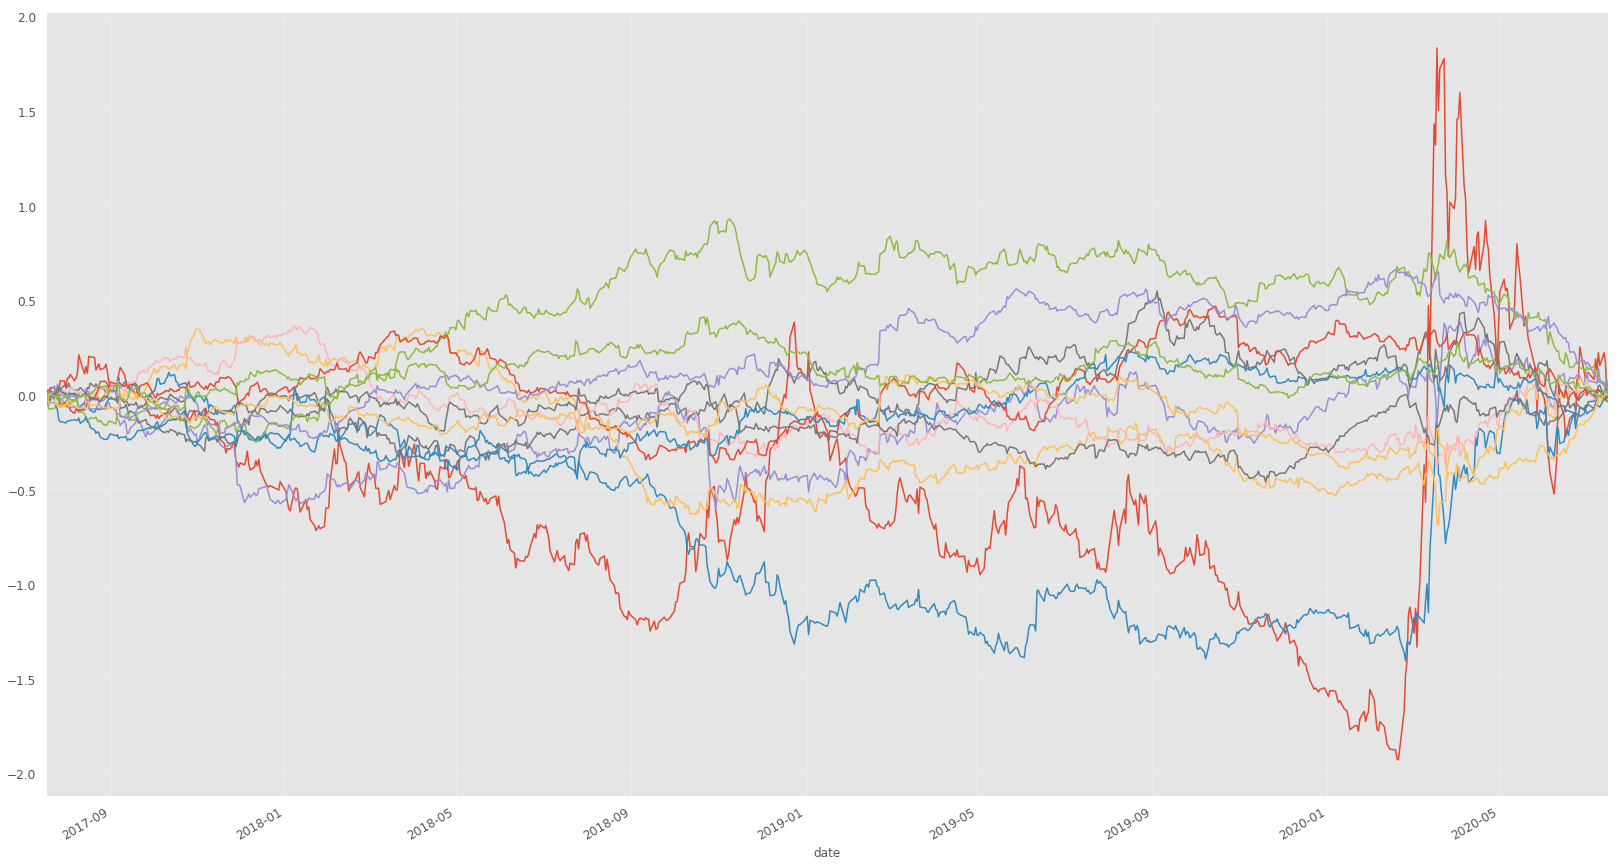

In [129]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[optimal_weights_regularized.index],num_factor_exposures=factor_exposures,weights=optimal_weights_regularized)

In [130]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 8.18 %


In [131]:
all_factors.to_csv('data/all_factors.csv')
optimal_weights_regularized.to_csv('data/optimal_weights_regularized.csv')
close.to_csv('data/close.csv')

In [132]:
import vlc
p = vlc.MediaPlayer("/home/k13104/Desktop/ES_PREL Whoosh Soft 7 - SFX Producer.mp3")
p.play()

0

In [133]:
print ('leverage is {}'.format(optimal_weights_regularized.abs().sum().round(2)[0]))
print ('long/short leverage balance is {}'.format(optimal_weights_regularized.sum().round(2)[0]))

leverage is 1.0
long/short leverage balance is 0.2


In [134]:
assert optimal_weights_regularized.sum().round(2)[0] == np.round((percent_long_leverage_target - percent_short_leverage_target),1)
assert optimal_weights_regularized.abs().sum().round(2)[0] == 1.0